In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
import geopandas as gpd
from geopandas.tools import geocode
from pandas.plotting import register_matplotlib_converters
import colorcet as cc
import pycountry
register_matplotlib_converters()

import plotly
plotly.offline.init_notebook_mode(connected=True)

# this line tells jupyter notebook to put the plots in the notebook rather than saving them to file.
%matplotlib inline

# this line makes plots prettier on mac retina screens. If you don't have one it shouldn't do anything.
%config InlineBackend.figure_format = 'retina'

## Loading data

In [199]:
population_df = pd.read_csv('./data/population.csv', thousands = ',')
average_rainfall_df = pd.read_csv('./data/average_rainfall.csv', thousands = ',')
average_temperature_df = pd.read_csv('./data/average_temperature.csv', thousands = ',')
covid_19 = pd.read_csv('./data/owid-covid-data.csv', thousands = ',')
gdp_df = pd.read_csv('./data/gdp.csv')
# stringency_df = pd.read_csv('./data/stringency_index.csv', thousands = ',')
median_age_df = pd.read_csv('./data/median_age.csv', thousands = ',')

In [200]:
average_rainfall_df

,avg_rainfall,country_name
0,2722,Brunei
1,1904,Cambodia
2,2702,Indonesia
3,1834,Laos
4,2875,Malaysia
5,2091,Myanmar
6,2348,Philippines
7,2497,Singapore
8,1622,Thailand
9,1500,Timor Leste


# Data preprocessing
## Check NA values

In [201]:
df_list = [population_df, gdp_df, median_age_df,
           average_rainfall_df, average_temperature_df]
for i in range(len(df_list)):
    print("**SUM of NA Values**")
    print(df_list[i].isna().sum())

**SUM of NA Values**
area            0
country_name    0
population      0
dtype: int64
**SUM of NA Values**
country_name    0
gdp             0
dtype: int64
**SUM of NA Values**
country_name    0
median_age      0
dtype: int64
**SUM of NA Values**
avg_rainfall    0
country_name    0
dtype: int64
**SUM of NA Values**
avg_temp        0
country_name    0
dtype: int64


## Covid 19 Dataset
### Filtering South East Asia countries

In [202]:
sea_countries = ['Brunei', 'Cambodia', 'Indonesia', 'Malaysia', 'Myanmar', 'Laos',
                           'Philippines', 'Singapore', 'Thailand', 'Timor', 'Vietnam']
covid_19= covid_19[covid_19['location'].isin(sea_countries)]
covid_19

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
20342,BRN,Asia,Brunei,2020-03-09,1.0,1.0,NaN,NaN,NaN,NaN,...,2.0,30.9,NaN,2.7,75.86,0.838,NaN,NaN,NaN,NaN
20343,BRN,Asia,Brunei,2020-03-10,1.0,0.0,NaN,NaN,NaN,NaN,...,2.0,30.9,NaN,2.7,75.86,0.838,NaN,NaN,NaN,NaN
20344,BRN,Asia,Brunei,2020-03-11,11.0,10.0,NaN,NaN,NaN,NaN,...,2.0,30.9,NaN,2.7,75.86,0.838,NaN,NaN,NaN,NaN
20345,BRN,Asia,Brunei,2020-03-12,11.0,0.0,NaN,NaN,NaN,NaN,...,2.0,30.9,NaN,2.7,75.86,0.838,NaN,NaN,NaN,NaN
20346,BRN,Asia,Brunei,2020-03-13,37.0,26.0,NaN,NaN,NaN,NaN,...,2.0,30.9,NaN,2.7,75.86,0.838,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145308,VNM,Asia,Vietnam,2021-12-14,1443648.0,15220.0,15160.714,28333.0,252.0,233.286,...,1.0,45.9,85.847,2.6,75.40,0.704,NaN,NaN,NaN,NaN
145309,VNM,Asia,Vietnam,2021-12-15,1459175.0,15527.0,15293.286,28616.0,283.0,240.857,...,1.0,45.9,85.847,2.6,75.40,0.704,NaN,NaN,NaN,NaN
145310,VNM,Asia,Vietnam,2021-12-16,1493237.0,34062.0,17972.000,28857.0,241.0,238.714,...,1.0,45.9,85.847,2.6,75.40,0.704,NaN,NaN,NaN,NaN
145311,VNM,Asia,Vietnam,2021-12-17,1508473.0,15236.0,18028.714,29103.0,246.0,243.000,...,1.0,45.9,85.847,2.6,75.40,0.704,NaN,NaN,NaN,NaN


### Select necessary columns

In [203]:
covid_19.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [204]:
selected_columns = ['location', 'date', 'total_cases', 'new_cases', 'total_deaths', 
                    'new_deaths', 'new_tests', 'total_tests',
                    'new_vaccinations', 'total_vaccinations','stringency_index']
covid_19 = covid_19[selected_columns].fillna(0)

In [205]:
covid_19.replace({'Timor': 'Timor Leste'}, inplace=True)

In [206]:
covid_19[covid_19['location']=='Timor Leste']

,location,date,total_cases,new_cases,total_deaths,new_deaths,new_tests,total_tests,new_vaccinations,total_vaccinations,stringency_index
132969,Timor Leste,2020-03-22,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.89
132970,Timor Leste,2020-03-23,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.56
132971,Timor Leste,2020-03-24,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.56
132972,Timor Leste,2020-03-25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.56
132973,Timor Leste,2020-03-26,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.56
...,...,...,...,...,...,...,...,...,...,...,...
133601,Timor Leste,2021-12-14,19830.0,1.0,122.0,0.0,0.0,0.0,0.0,0.0,0.00
133602,Timor Leste,2021-12-15,19830.0,0.0,122.0,0.0,0.0,0.0,0.0,0.0,0.00
133603,Timor Leste,2021-12-16,19830.0,0.0,122.0,0.0,0.0,0.0,0.0,0.0,0.00
133604,Timor Leste,2021-12-17,19832.0,2.0,122.0,0.0,0.0,0.0,0.0,0.0,0.00


### Rename to formal format

In [207]:
covid_19 = covid_19.rename(columns={"location": "Country name", "date": "Date", "total_cases": "Total cases",
                        "new_cases": "New cases", "total_deaths": "Total deaths", "new_deaths": "New deaths",
                         'total_tests': "Total tests", 'new_tests': "New tests", 'total_vaccinations': "Total vaccineinations",
                        'new_vaccinations': "New vaccineinations", 'stringency_index': "Stringency index"})

In [208]:
covid_19

,Country name,Date,Total cases,New cases,Total deaths,New deaths,New tests,Total tests,New vaccineinations,Total vaccineinations,Stringency index
20342,Brunei,2020-03-09,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,19.44
20343,Brunei,2020-03-10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.44
20344,Brunei,2020-03-11,11.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,30.56
20345,Brunei,2020-03-12,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.56
20346,Brunei,2020-03-13,37.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,50.00
...,...,...,...,...,...,...,...,...,...,...,...
145308,Vietnam,2021-12-14,1443648.0,15220.0,28333.0,252.0,0.0,33773778.0,0.0,135202794.0,0.00
145309,Vietnam,2021-12-15,1459175.0,15527.0,28616.0,283.0,119616.0,33893394.0,534174.0,135736968.0,0.00
145310,Vietnam,2021-12-16,1493237.0,34062.0,28857.0,241.0,118491.0,34011885.0,0.0,0.0,0.00
145311,Vietnam,2021-12-17,1508473.0,15236.0,29103.0,246.0,0.0,0.0,0.0,137574609.0,0.00


## Remaining dataset
### Merging datasets together

In [209]:
df = population_df

for i in range(1, len(df_list)):
    df = pd.merge(df, df_list[i], on='country_name', how='inner')
df

,area,country_name,population,gdp,median_age,avg_rainfall,avg_temp
0,1904569,Indonesia,273523615,"$1,015,420,587,285",30.2,2702,25.85
1,342353,Philippines,109581078,"$313,595,208,737",23.5,2348,25.85
2,331212,Vietnam,97338579,"$223,779,865,815",30.5,1821,24.45
3,513120,Thailand,69799978,"$455,302,682,986",37.7,1622,26.30
4,676578,Myanmar,54409800,"$67,068,745,521",28.2,2091,13.05
5,330803,Malaysia,32365999,"$314,710,259,511",28.5,2875,25.40
6,181035,Cambodia,16718965,"$22,158,209,503",25.3,1904,26.80
7,236800,Laos,7275560,"$16,853,087,485",23.0,1834,22.80
8,710,Singapore,5850342,"$323,907,234,412",34.6,2497,26.45
9,14874,Timor Leste,1318445,"$2,954,621,000",18.9,1500,25.25


In [210]:
# df = df.sort_values('country_name')
# df

In [211]:
# country_name_column = df.pop('country_name')
# df.insert(0, 'country_name', country_name_column)
# df

In [212]:
df

,area,country_name,population,gdp,median_age,avg_rainfall,avg_temp
0,1904569,Indonesia,273523615,"$1,015,420,587,285",30.2,2702,25.85
1,342353,Philippines,109581078,"$313,595,208,737",23.5,2348,25.85
2,331212,Vietnam,97338579,"$223,779,865,815",30.5,1821,24.45
3,513120,Thailand,69799978,"$455,302,682,986",37.7,1622,26.30
4,676578,Myanmar,54409800,"$67,068,745,521",28.2,2091,13.05
5,330803,Malaysia,32365999,"$314,710,259,511",28.5,2875,25.40
6,181035,Cambodia,16718965,"$22,158,209,503",25.3,1904,26.80
7,236800,Laos,7275560,"$16,853,087,485",23.0,1834,22.80
8,710,Singapore,5850342,"$323,907,234,412",34.6,2497,26.45
9,14874,Timor Leste,1318445,"$2,954,621,000",18.9,1500,25.25


### Rename columns


In [213]:
df = df.rename(columns={"country_name": "Country name", "population": "Population", "area": "Area", "gdp": "GDP",
                        "median_age": "Median age", "avg_rainfall": "Average rainfall",
                       "avg_temp": "Average temperature", "stringency_index": "Stringency index"})

In [214]:
df

,Area,Country name,Population,GDP,Median age,Average rainfall,Average temperature
0,1904569,Indonesia,273523615,"$1,015,420,587,285",30.2,2702,25.85
1,342353,Philippines,109581078,"$313,595,208,737",23.5,2348,25.85
2,331212,Vietnam,97338579,"$223,779,865,815",30.5,1821,24.45
3,513120,Thailand,69799978,"$455,302,682,986",37.7,1622,26.30
4,676578,Myanmar,54409800,"$67,068,745,521",28.2,2091,13.05
5,330803,Malaysia,32365999,"$314,710,259,511",28.5,2875,25.40
6,181035,Cambodia,16718965,"$22,158,209,503",25.3,1904,26.80
7,236800,Laos,7275560,"$16,853,087,485",23.0,1834,22.80
8,710,Singapore,5850342,"$323,907,234,412",34.6,2497,26.45
9,14874,Timor Leste,1318445,"$2,954,621,000",18.9,1500,25.25


In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 0 to 10
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Area                 11 non-null     int64  
 1   Country name         11 non-null     object 
 2   Population           11 non-null     int64  
 3   GDP                  11 non-null     object 
 4   Median age           11 non-null     float64
 5   Average rainfall     11 non-null     int64  
 6   Average temperature  11 non-null     float64
dtypes: float64(2), int64(3), object(2)
memory usage: 704.0+ bytes


In [216]:
df['GDP'] = df['GDP'].str[1:]
df['GDP'] = df['GDP'].str.replace(',', '').astype(float)

In [217]:
df = df.sort_values('Country name', ignore_index=True)

In [218]:
df

,Area,Country name,Population,GDP,Median age,Average rainfall,Average temperature
0,5765,Brunei,437479,1.212809e+10,30.2,2722,26.85
1,181035,Cambodia,16718965,2.215821e+10,25.3,1904,26.80
2,1904569,Indonesia,273523615,1.015421e+12,30.2,2702,25.85
3,236800,Laos,7275560,1.685309e+10,23.0,1834,22.80
4,330803,Malaysia,32365999,3.147103e+11,28.5,2875,25.40
5,676578,Myanmar,54409800,6.706875e+10,28.2,2091,13.05
6,342353,Philippines,109581078,3.135952e+11,23.5,2348,25.85
7,710,Singapore,5850342,3.239072e+11,34.6,2497,26.45
8,513120,Thailand,69799978,4.553027e+11,37.7,1622,26.30
9,14874,Timor Leste,1318445,2.954621e+09,18.9,1500,25.25


In [219]:
df.drop_duplicates(inplace=True)

In [220]:
s = covid_19.groupby('Country name').sum()
total_case = s['New cases'].tolist()
total_deaths = s['New deaths'].tolist()
df['Total cases'] = total_case
df['Total deaths'] = total_deaths

In [221]:
column_order = ["Country name", "Total cases", "Total deaths", "Population", "Area", "GDP", 
                "Median age", "Average rainfall", "Average temperature"]
df = df.reindex(columns=column_order)

In [222]:
df

,Country name,Total cases,Total deaths,Population,Area,GDP,Median age,Average rainfall,Average temperature
0,Brunei,15386.0,98.0,437479,5765,1.212809e+10,30.2,2722,26.85
1,Cambodia,120410.0,3003.0,16718965,181035,2.215821e+10,25.3,1904,26.80
2,Indonesia,4260380.0,143998.0,273523615,1904569,1.015421e+12,30.2,2702,25.85
3,Laos,97505.0,268.0,7275560,236800,1.685309e+10,23.0,1834,22.80
4,Malaysia,2715847.0,31073.0,32365999,330803,3.147103e+11,28.5,2875,25.40
5,Myanmar,528101.0,19213.0,54409800,676578,6.706875e+10,28.2,2091,13.05
6,Philippines,2837555.0,50675.0,109581078,342353,3.135952e+11,23.5,2348,25.85
7,Singapore,275655.0,810.0,5850342,710,3.239072e+11,34.6,2497,26.45
8,Thailand,2188625.0,21355.0,69799978,513120,4.553027e+11,37.7,1622,26.30
9,Timor Leste,19833.0,122.0,1318445,14874,2.954621e+09,18.9,1500,25.25


# EDA
## Univariable
### Number of reported cases

In [223]:
df_cases = covid_19[['Country name', 'Date', 'New cases']]
df_cases

,Country name,Date,New cases
20342,Brunei,2020-03-09,1.0
20343,Brunei,2020-03-10,0.0
20344,Brunei,2020-03-11,10.0
20345,Brunei,2020-03-12,0.0
20346,Brunei,2020-03-13,26.0
...,...,...,...
145308,Vietnam,2021-12-14,15220.0
145309,Vietnam,2021-12-15,15527.0
145310,Vietnam,2021-12-16,34062.0
145311,Vietnam,2021-12-17,15236.0


In [224]:
df_cases.set_index('Date', inplace=True)
df_cases.index

Index(['2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
       '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18',
       ...
       '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12', '2021-12-13',
       '2021-12-14', '2021-12-15', '2021-12-16', '2021-12-17', '2021-12-18'],
      dtype='object', name='Date', length=7394)

In [225]:
df_cases.index = pd.DatetimeIndex(df_cases.index)
df_cases = df_cases.groupby('Country name').resample('MS').agg({'New cases':'sum'})
df_cases

New cases
Country name Date                 
Brunei       2020-03-01      129.0
             2020-04-01        9.0
             2020-05-01        3.0
             2020-06-01        0.0
             2020-07-01        0.0
...                            ...
Vietnam      2021-08-01   312036.0
             2021-09-01   328659.0
             2021-10-01   130367.0
             2021-11-01   316960.0
             2021-12-01   286286.0

[254 rows x 1 columns]

In [226]:
df_cases.index

MultiIndex([( 'Brunei', '2020-03-01'),
            ( 'Brunei', '2020-04-01'),
            ( 'Brunei', '2020-05-01'),
            ( 'Brunei', '2020-06-01'),
            ( 'Brunei', '2020-07-01'),
            ( 'Brunei', '2020-08-01'),
            ( 'Brunei', '2020-09-01'),
            ( 'Brunei', '2020-10-01'),
            ( 'Brunei', '2020-11-01'),
            ( 'Brunei', '2020-12-01'),
            ...
            ('Vietnam', '2021-03-01'),
            ('Vietnam', '2021-04-01'),
            ('Vietnam', '2021-05-01'),
            ('Vietnam', '2021-06-01'),
            ('Vietnam', '2021-07-01'),
            ('Vietnam', '2021-08-01'),
            ('Vietnam', '2021-09-01'),
            ('Vietnam', '2021-10-01'),
            ('Vietnam', '2021-11-01'),
            ('Vietnam', '2021-12-01')],
           names=['Country name', 'Date'], length=254)

In [227]:
df_cases.reset_index(inplace=True, level='Date')
df_cases.reset_index(inplace=True, level='Country name')
df_cases

,Country name,Date,New cases
0,Brunei,2020-03-01,129.0
1,Brunei,2020-04-01,9.0
2,Brunei,2020-05-01,3.0
3,Brunei,2020-06-01,0.0
4,Brunei,2020-07-01,0.0
...,...,...,...
249,Vietnam,2021-08-01,312036.0
250,Vietnam,2021-09-01,328659.0
251,Vietnam,2021-10-01,130367.0
252,Vietnam,2021-11-01,316960.0


In [228]:
df_cases.columns

Index(['Country name', 'Date', 'New cases'], dtype='object')

### Simple statistic

In [229]:
df_cases.describe()

,New cases
count,2.540000e+02
mean,5.741600e+04
std,1.358320e+05
min,0.000000e+00
25%,5.250000e+01
50%,1.784000e+03
75%,4.165875e+04
max,1.231386e+06


In [230]:
df_cases = df_cases.pivot(index='Country name', 
              columns='Date', 
              values='New cases')

In [231]:
df_cases

Date,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,...,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01
Country name,,,,,,,,,,,,,,,,,,,,,
Brunei,NaN,NaN,129.0,9.0,3.0,0.0,0.0,3.0,2.0,2.0,...,26.0,12.0,18.0,18.0,77.0,2375.0,4404.0,6014.0,1928.0,328.0
Cambodia,1.0,0.0,108.0,13.0,3.0,16.0,98.0,35.0,3.0,14.0,...,1620.0,10962.0,16692.0,20291.0,26858.0,15812.0,19596.0,5871.0,1612.0,276.0
Indonesia,NaN,NaN,1528.0,8590.0,16355.0,29912.0,51991.0,66420.0,112212.0,123080.0,...,177078.0,156656.0,153335.0,356569.0,1231386.0,680143.0,125303.0,29254.0,12051.0,3971.0
Laos,NaN,NaN,9.0,10.0,0.0,0.0,1.0,2.0,1.0,1.0,...,4.0,708.0,1155.0,209.0,4178.0,8716.0,8831.0,16425.0,33467.0,23767.0
Malaysia,8.0,21.0,2737.0,3236.0,1817.0,820.0,337.0,364.0,1884.0,20324.0,...,44748.0,63213.0,163644.0,179622.0,361293.0,632982.0,499441.0,225947.0,161140.0,83065.0
Myanmar,NaN,NaN,15.0,136.0,73.0,75.0,54.0,529.0,12491.0,39333.0,...,538.0,383.0,812.0,13648.0,141908.0,100097.0,64794.0,35997.0,22329.0,5699.0
Philippines,1.0,2.0,2081.0,6404.0,9598.0,19428.0,55840.0,127465.0,90875.0,69035.0,...,170936.0,290172.0,192841.0,182258.0,176406.0,400892.0,560109.0,237310.0,45458.0,4821.0
Singapore,13.0,89.0,824.0,15243.0,18715.0,9023.0,8298.0,4607.0,953.0,250.0,...,445.0,764.0,906.0,528.0,2402.0,2639.0,28901.0,101853.0,66351.0,10930.0
Thailand,15.0,23.0,1609.0,1303.0,127.0,90.0,139.0,102.0,157.0,215.0,...,2832.0,36290.0,94639.0,99509.0,337986.0,607442.0,398746.0,308549.0,203848.0,72757.0


In [232]:
df_cases= df_cases.transpose()

In [233]:
# datetime_index = pd.DatetimeIndex(df_cases.index)


In [234]:
df_cases

Country name,Brunei,Cambodia,Indonesia,Laos,Malaysia,Myanmar,Philippines,Singapore,Thailand,Timor Leste,Vietnam
Date,,,,,,,,,,,
2020-01-01,NaN,1.0,NaN,NaN,8.0,NaN,1.0,13.0,15.0,NaN,2.0
2020-02-01,NaN,0.0,NaN,NaN,21.0,NaN,2.0,89.0,23.0,NaN,14.0
2020-03-01,129.0,108.0,1528.0,9.0,2737.0,15.0,2081.0,824.0,1609.0,1.0,196.0
2020-04-01,9.0,13.0,8590.0,10.0,3236.0,136.0,6404.0,15243.0,1303.0,23.0,58.0
2020-05-01,3.0,3.0,16355.0,0.0,1817.0,73.0,9598.0,18715.0,127.0,0.0,58.0
2020-06-01,0.0,16.0,29912.0,0.0,820.0,75.0,19428.0,9023.0,90.0,0.0,27.0
2020-07-01,0.0,98.0,51991.0,1.0,337.0,54.0,55840.0,8298.0,139.0,0.0,203.0
2020-08-01,3.0,35.0,66420.0,2.0,364.0,529.0,127465.0,4607.0,102.0,3.0,486.0
2020-09-01,2.0,3.0,112212.0,1.0,1884.0,12491.0,90875.0,953.0,157.0,1.0,50.0


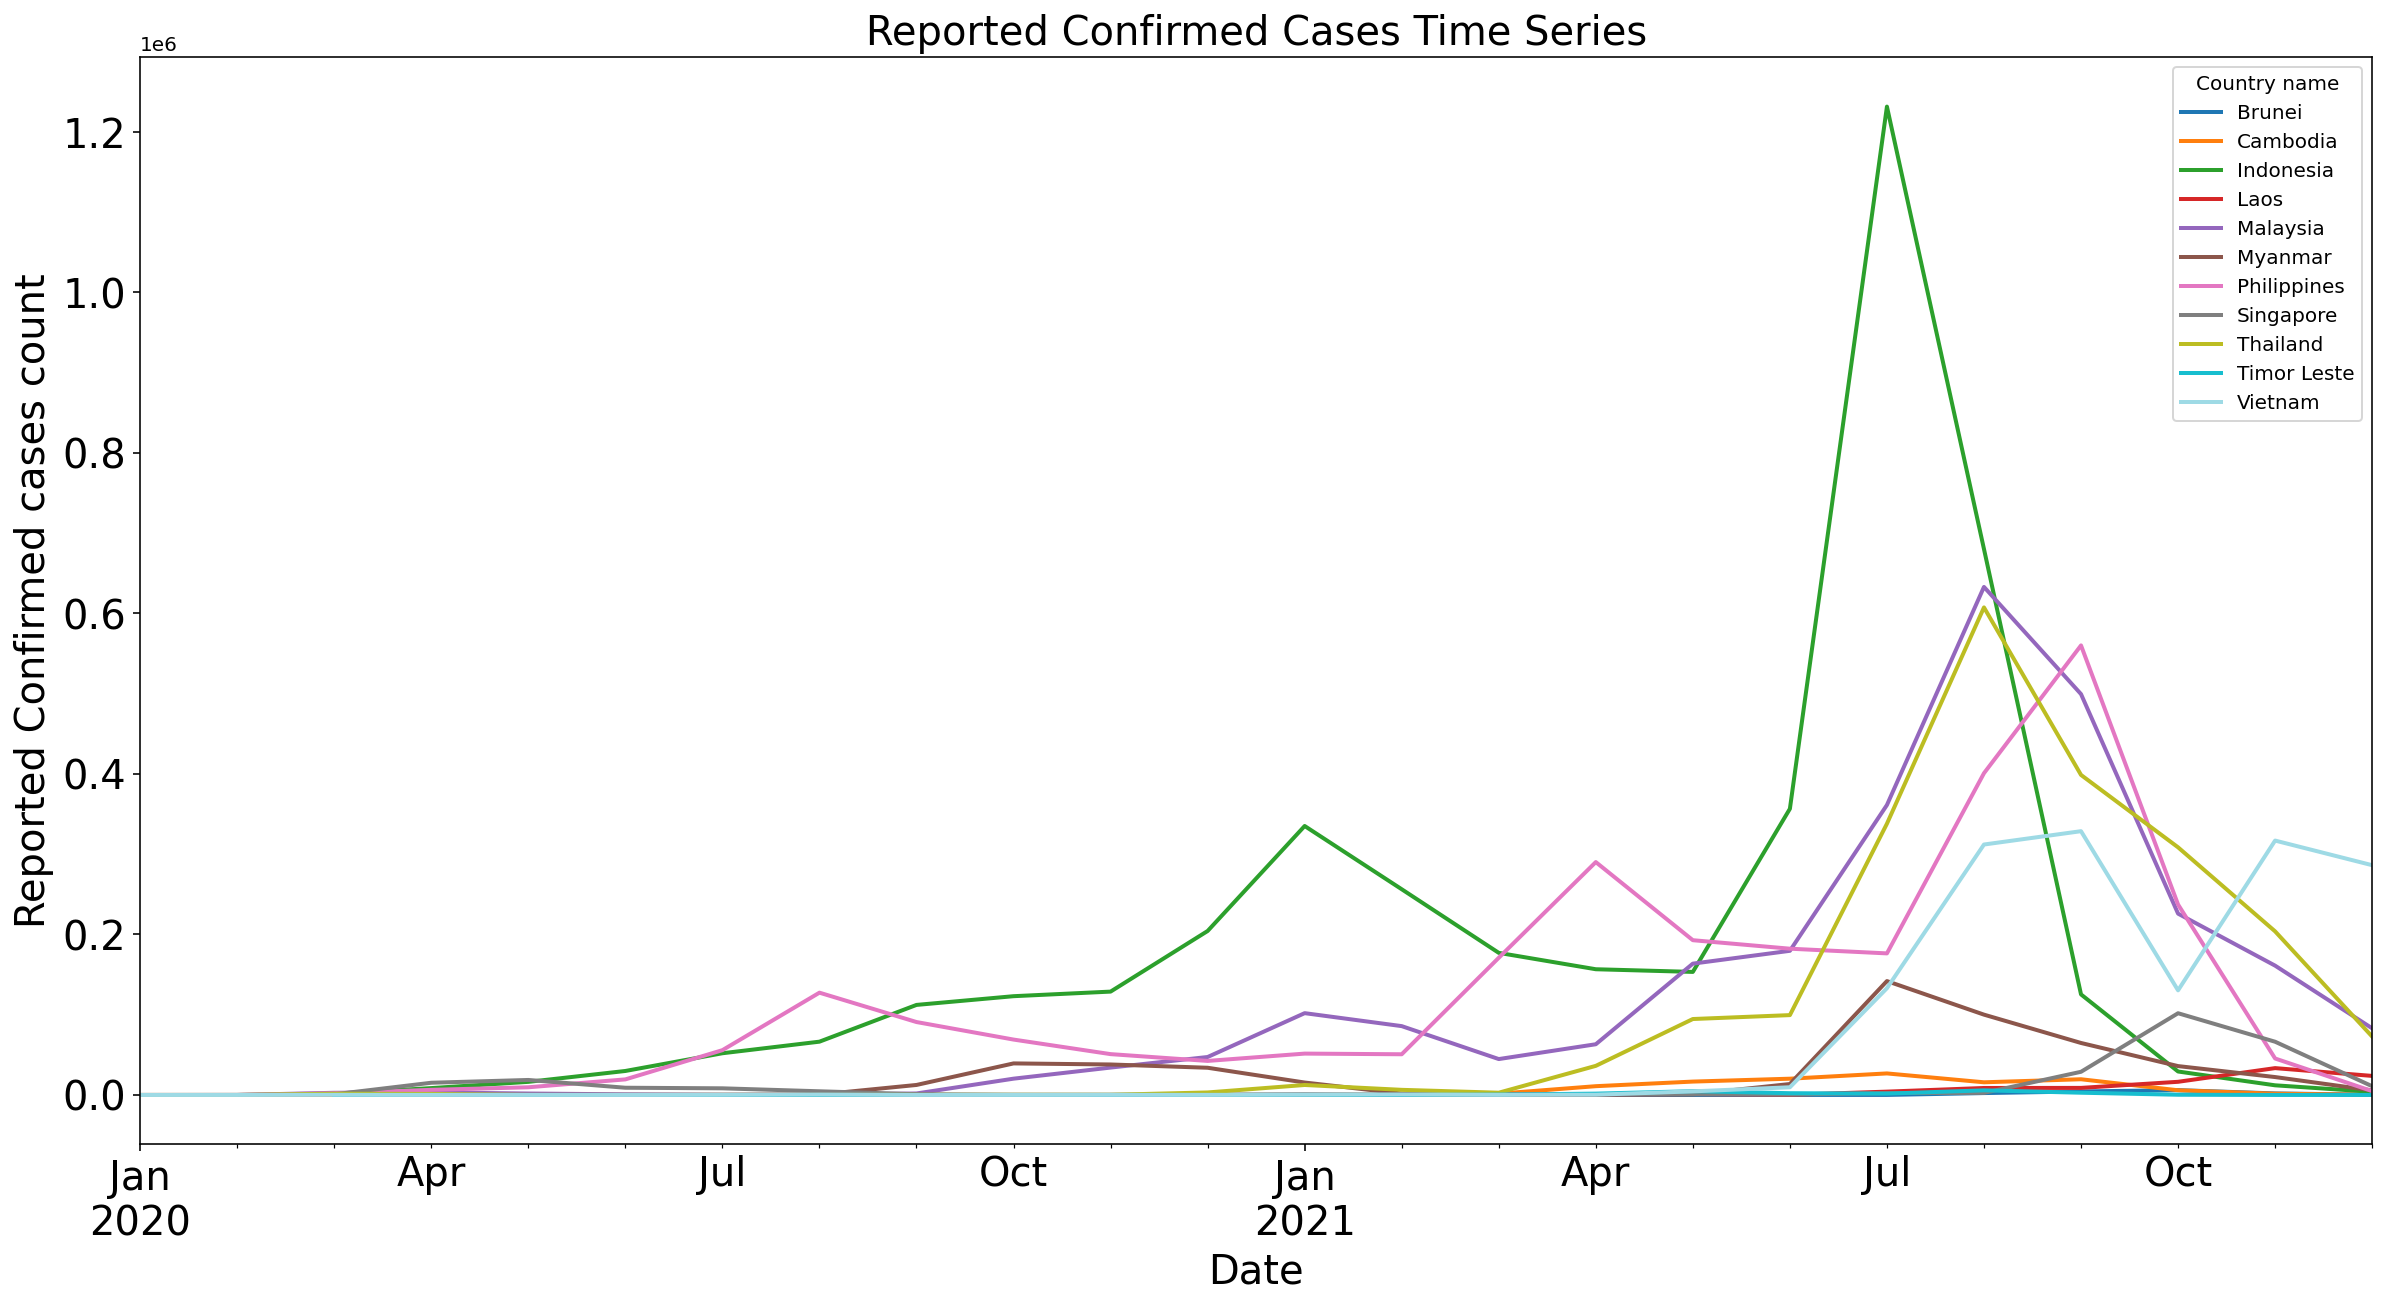

In [235]:
df_cases.plot(figsize=(20,10), linewidth=2, colormap='tab20', fontsize=20);
plt.xlabel('Date', fontsize=20);
plt.ylabel('Reported Confirmed cases count', fontsize=20);
plt.title('Reported Confirmed Cases Time Series', fontsize=20);

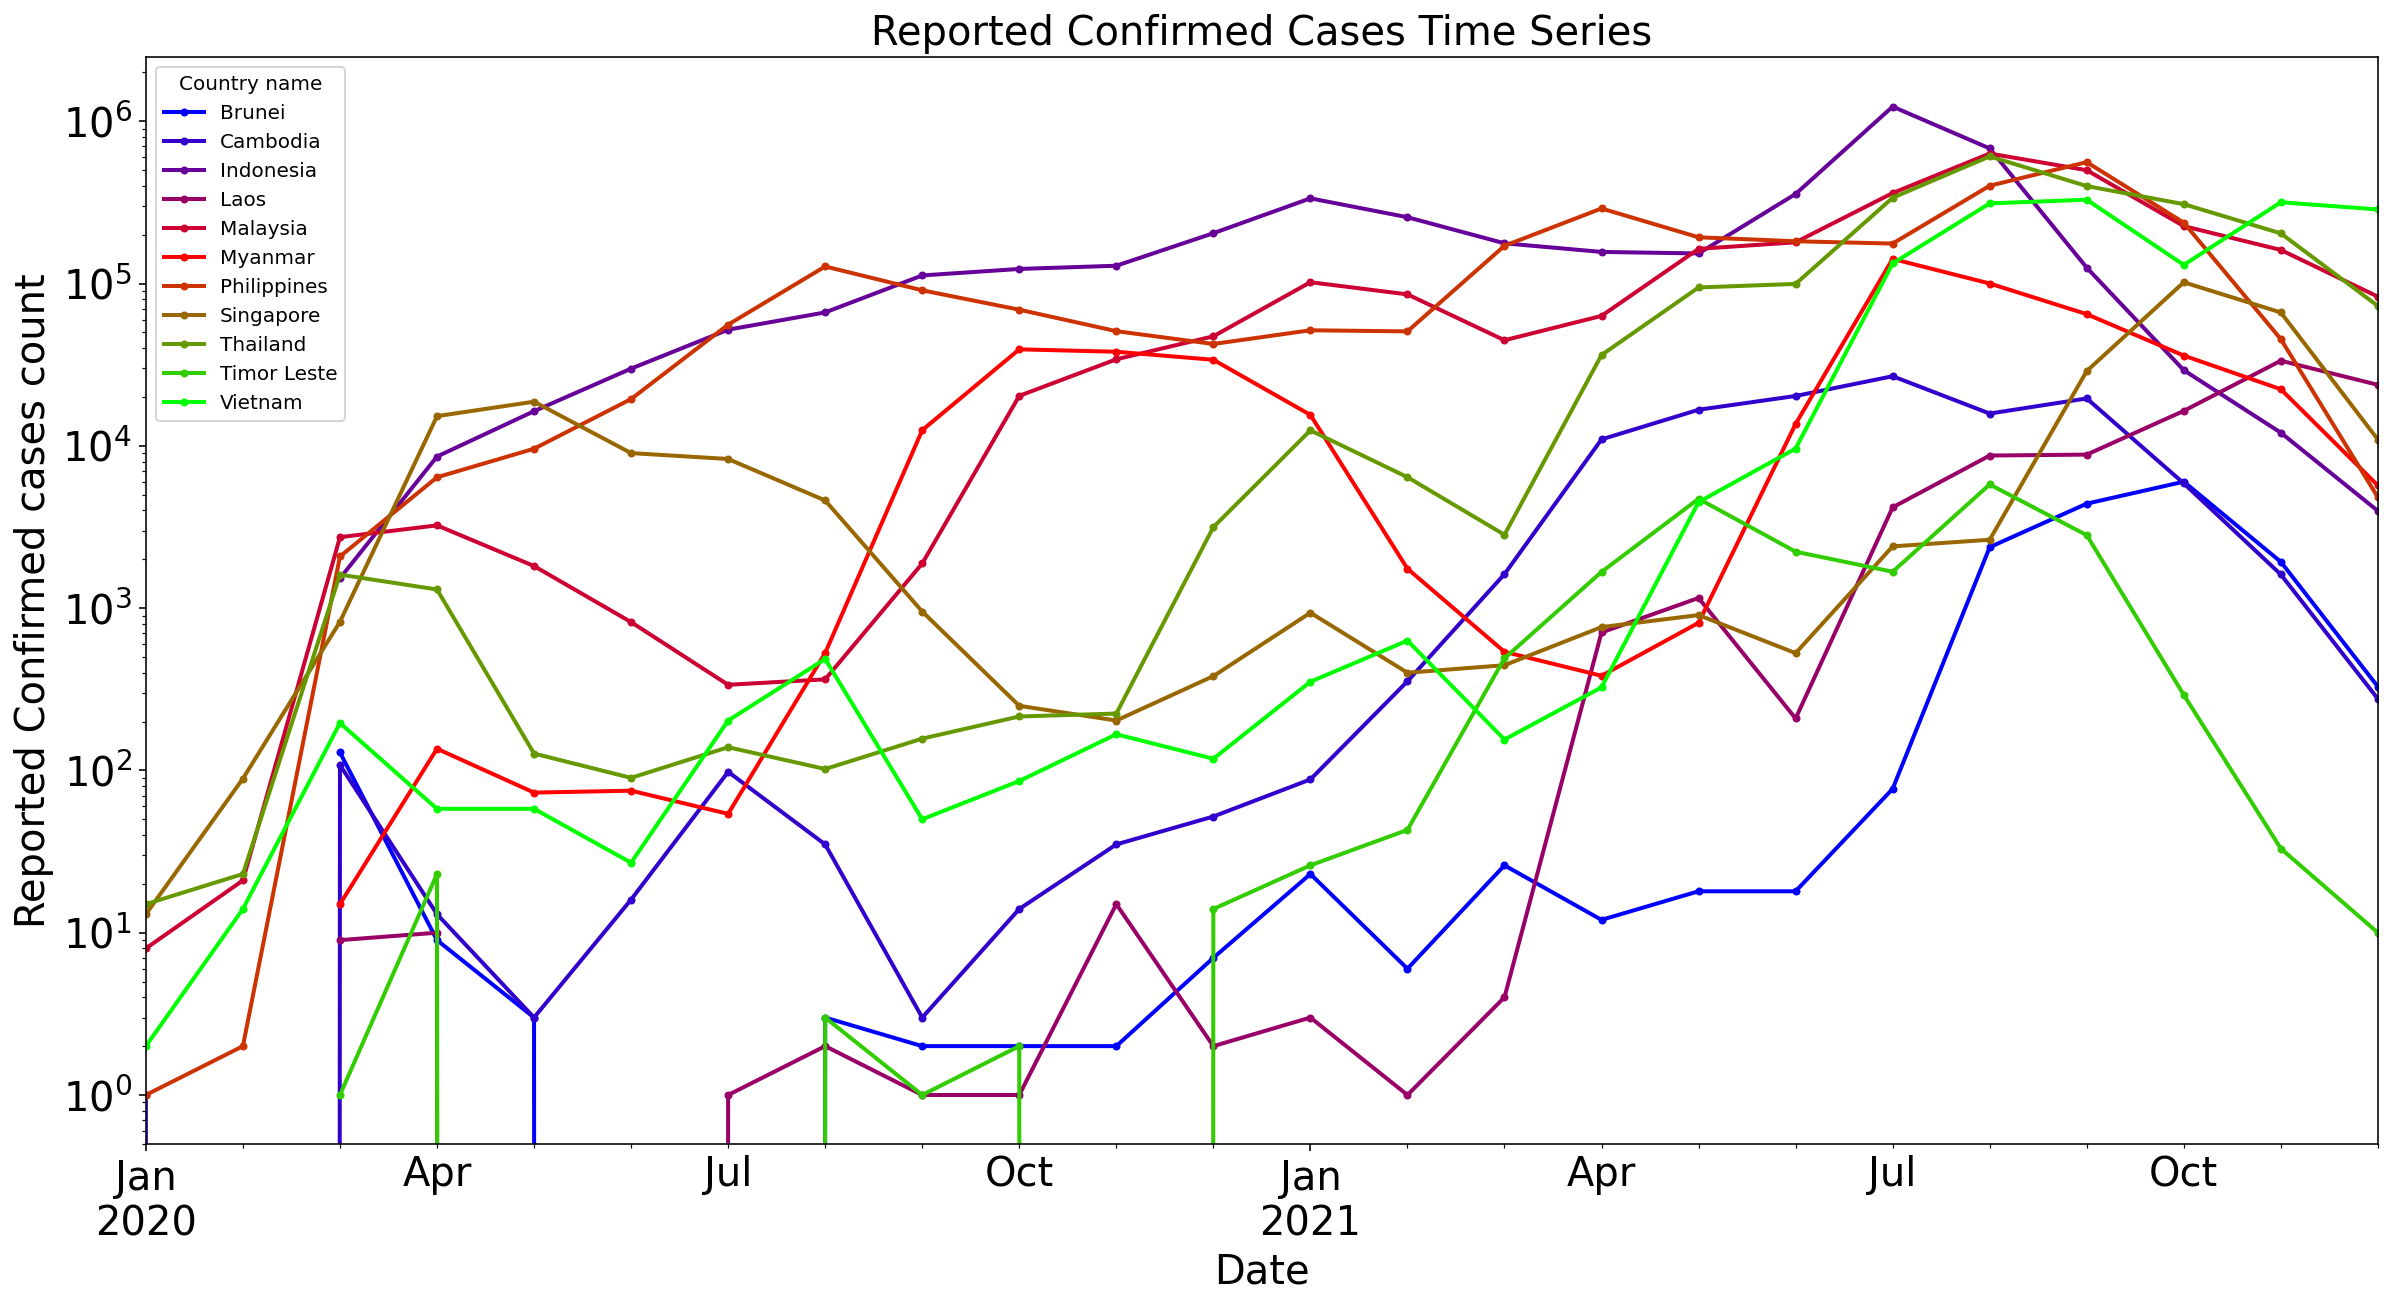

In [236]:
# Plot time series of several countries of interest
df_cases.plot(figsize=(20,10), linewidth=2, marker='.', colormap='brg', fontsize=20, logy=True)
plt.xlabel('Date', fontsize=20);
plt.ylabel('Reported Confirmed cases count', fontsize=20);
plt.title('Reported Confirmed Cases Time Series', fontsize=20);

## Number of reported death

In [237]:
df_deaths = covid_19[['Country name', 'Date', 'New deaths']]
df_deaths

,Country name,Date,New deaths
20342,Brunei,2020-03-09,0.0
20343,Brunei,2020-03-10,0.0
20344,Brunei,2020-03-11,0.0
20345,Brunei,2020-03-12,0.0
20346,Brunei,2020-03-13,0.0
...,...,...,...
145308,Vietnam,2021-12-14,252.0
145309,Vietnam,2021-12-15,283.0
145310,Vietnam,2021-12-16,241.0
145311,Vietnam,2021-12-17,246.0


In [238]:
df_deaths.set_index('Date', inplace=True)
df_deaths.index

Index(['2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
       '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18',
       ...
       '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12', '2021-12-13',
       '2021-12-14', '2021-12-15', '2021-12-16', '2021-12-17', '2021-12-18'],
      dtype='object', name='Date', length=7394)

In [239]:
df_deaths.index = pd.DatetimeIndex(df_deaths.index)
df_deaths = df_deaths.groupby('Country name').resample('MS').agg({'New deaths':'sum'})
df_deaths

New deaths
Country name Date                  
Brunei       2020-03-01         1.0
             2020-04-01         0.0
             2020-05-01         1.0
             2020-06-01         1.0
             2020-07-01         0.0
...                             ...
Vietnam      2021-08-01      9758.0
             2021-09-01      8237.0
             2021-10-01      2782.0
             2021-11-01      3169.0
             2021-12-01      4099.0

[254 rows x 1 columns]

In [240]:
df_deaths.index

MultiIndex([( 'Brunei', '2020-03-01'),
            ( 'Brunei', '2020-04-01'),
            ( 'Brunei', '2020-05-01'),
            ( 'Brunei', '2020-06-01'),
            ( 'Brunei', '2020-07-01'),
            ( 'Brunei', '2020-08-01'),
            ( 'Brunei', '2020-09-01'),
            ( 'Brunei', '2020-10-01'),
            ( 'Brunei', '2020-11-01'),
            ( 'Brunei', '2020-12-01'),
            ...
            ('Vietnam', '2021-03-01'),
            ('Vietnam', '2021-04-01'),
            ('Vietnam', '2021-05-01'),
            ('Vietnam', '2021-06-01'),
            ('Vietnam', '2021-07-01'),
            ('Vietnam', '2021-08-01'),
            ('Vietnam', '2021-09-01'),
            ('Vietnam', '2021-10-01'),
            ('Vietnam', '2021-11-01'),
            ('Vietnam', '2021-12-01')],
           names=['Country name', 'Date'], length=254)

In [241]:
# df_deaths.reset_index(inplace=True, level='Date')
df_deaths.reset_index(inplace=True, level='Country name')
df_deaths.reset_index(inplace=True, level='Date')
df_deaths

,Date,Country name,New deaths
0,2020-03-01,Brunei,1.0
1,2020-04-01,Brunei,0.0
2,2020-05-01,Brunei,1.0
3,2020-06-01,Brunei,1.0
4,2020-07-01,Brunei,0.0
...,...,...,...
249,2021-08-01,Vietnam,9758.0
250,2021-09-01,Vietnam,8237.0
251,2021-10-01,Vietnam,2782.0
252,2021-11-01,Vietnam,3169.0


In [242]:
df_deaths = df_deaths.pivot(index='Country name', 
              columns='Date', 
              values='New deaths')

In [243]:
df_deaths= df_deaths.transpose()

In [244]:
datetime_index = pd.DatetimeIndex(df_deaths.index)
df_deaths.index

DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [245]:
plt.figure(figsize=(25,8))
  
# ax = plt.axes()
# ax.grid(linewidth=0.4, color='#8f8f8f') 

# Plot time series of several countries of interest
# df_deaths.plot(figsize=(20,10), linewidth=2, marker='.', colormap='tab20', fontsize=20)
# ax.set_xlabel('Date', fontsize=20);
# ax.set_ylabel('Reported Confirmed deaths count', fontsize=20);
# plt.title('Reported Confirmed deaths Time Series', fontsize=20);

# ax.annotate('Second Lockdown 15th April',
#             xy=(15.2, 860),
#             xytext=(19.9,500),
#             color='white',
#             size='25',
#             arrowprops=dict(color='white',
#                             linewidth=0.025))

<Figure size 1800x576 with 0 Axes>

<Figure size 1800x576 with 0 Axes>

In [246]:
# Plot time series of several countries of interest
# df_deaths.plot(figsize=(20,10), linewidth=2, marker='.', colormap='brg', fontsize=20, logy=True)
# plt.xlabel('Date', fontsize=20);
# plt.ylabel('Reported Confirmed cases count', fontsize=20);
# plt.title('Reported Confirmed Cases Time Series', fontsize=20);

In [247]:
for col in df_deaths.columns:
    df_deaths.loc[(df_deaths[col] < 100),col] = None

# Check out tail
df_deaths.tail()

Country name,Brunei,Cambodia,Indonesia,Laos,Malaysia,Myanmar,Philippines,Singapore,Thailand,Timor Leste,Vietnam
Date,,,,,,,,,,,
2021-08-01,NaN,506.0,38904.0,NaN,7640.0,6055.0,5559.0,NaN,6732.0,NaN,9758.0
2021-09-01,NaN,416.0,8916.0,NaN,9671.0,2346.0,4846.0,NaN,5138.0,NaN,8237.0
2021-10-01,NaN,469.0,1466.0,NaN,2577.0,962.0,4878.0,312.0,2478.0,NaN,2782.0
2021-11-01,NaN,152.0,425.0,105.0,1513.0,407.0,5373.0,311.0,1566.0,NaN,3169.0
2021-12-01,NaN,NaN,168.0,NaN,648.0,109.0,2130.0,NaN,584.0,NaN,4099.0


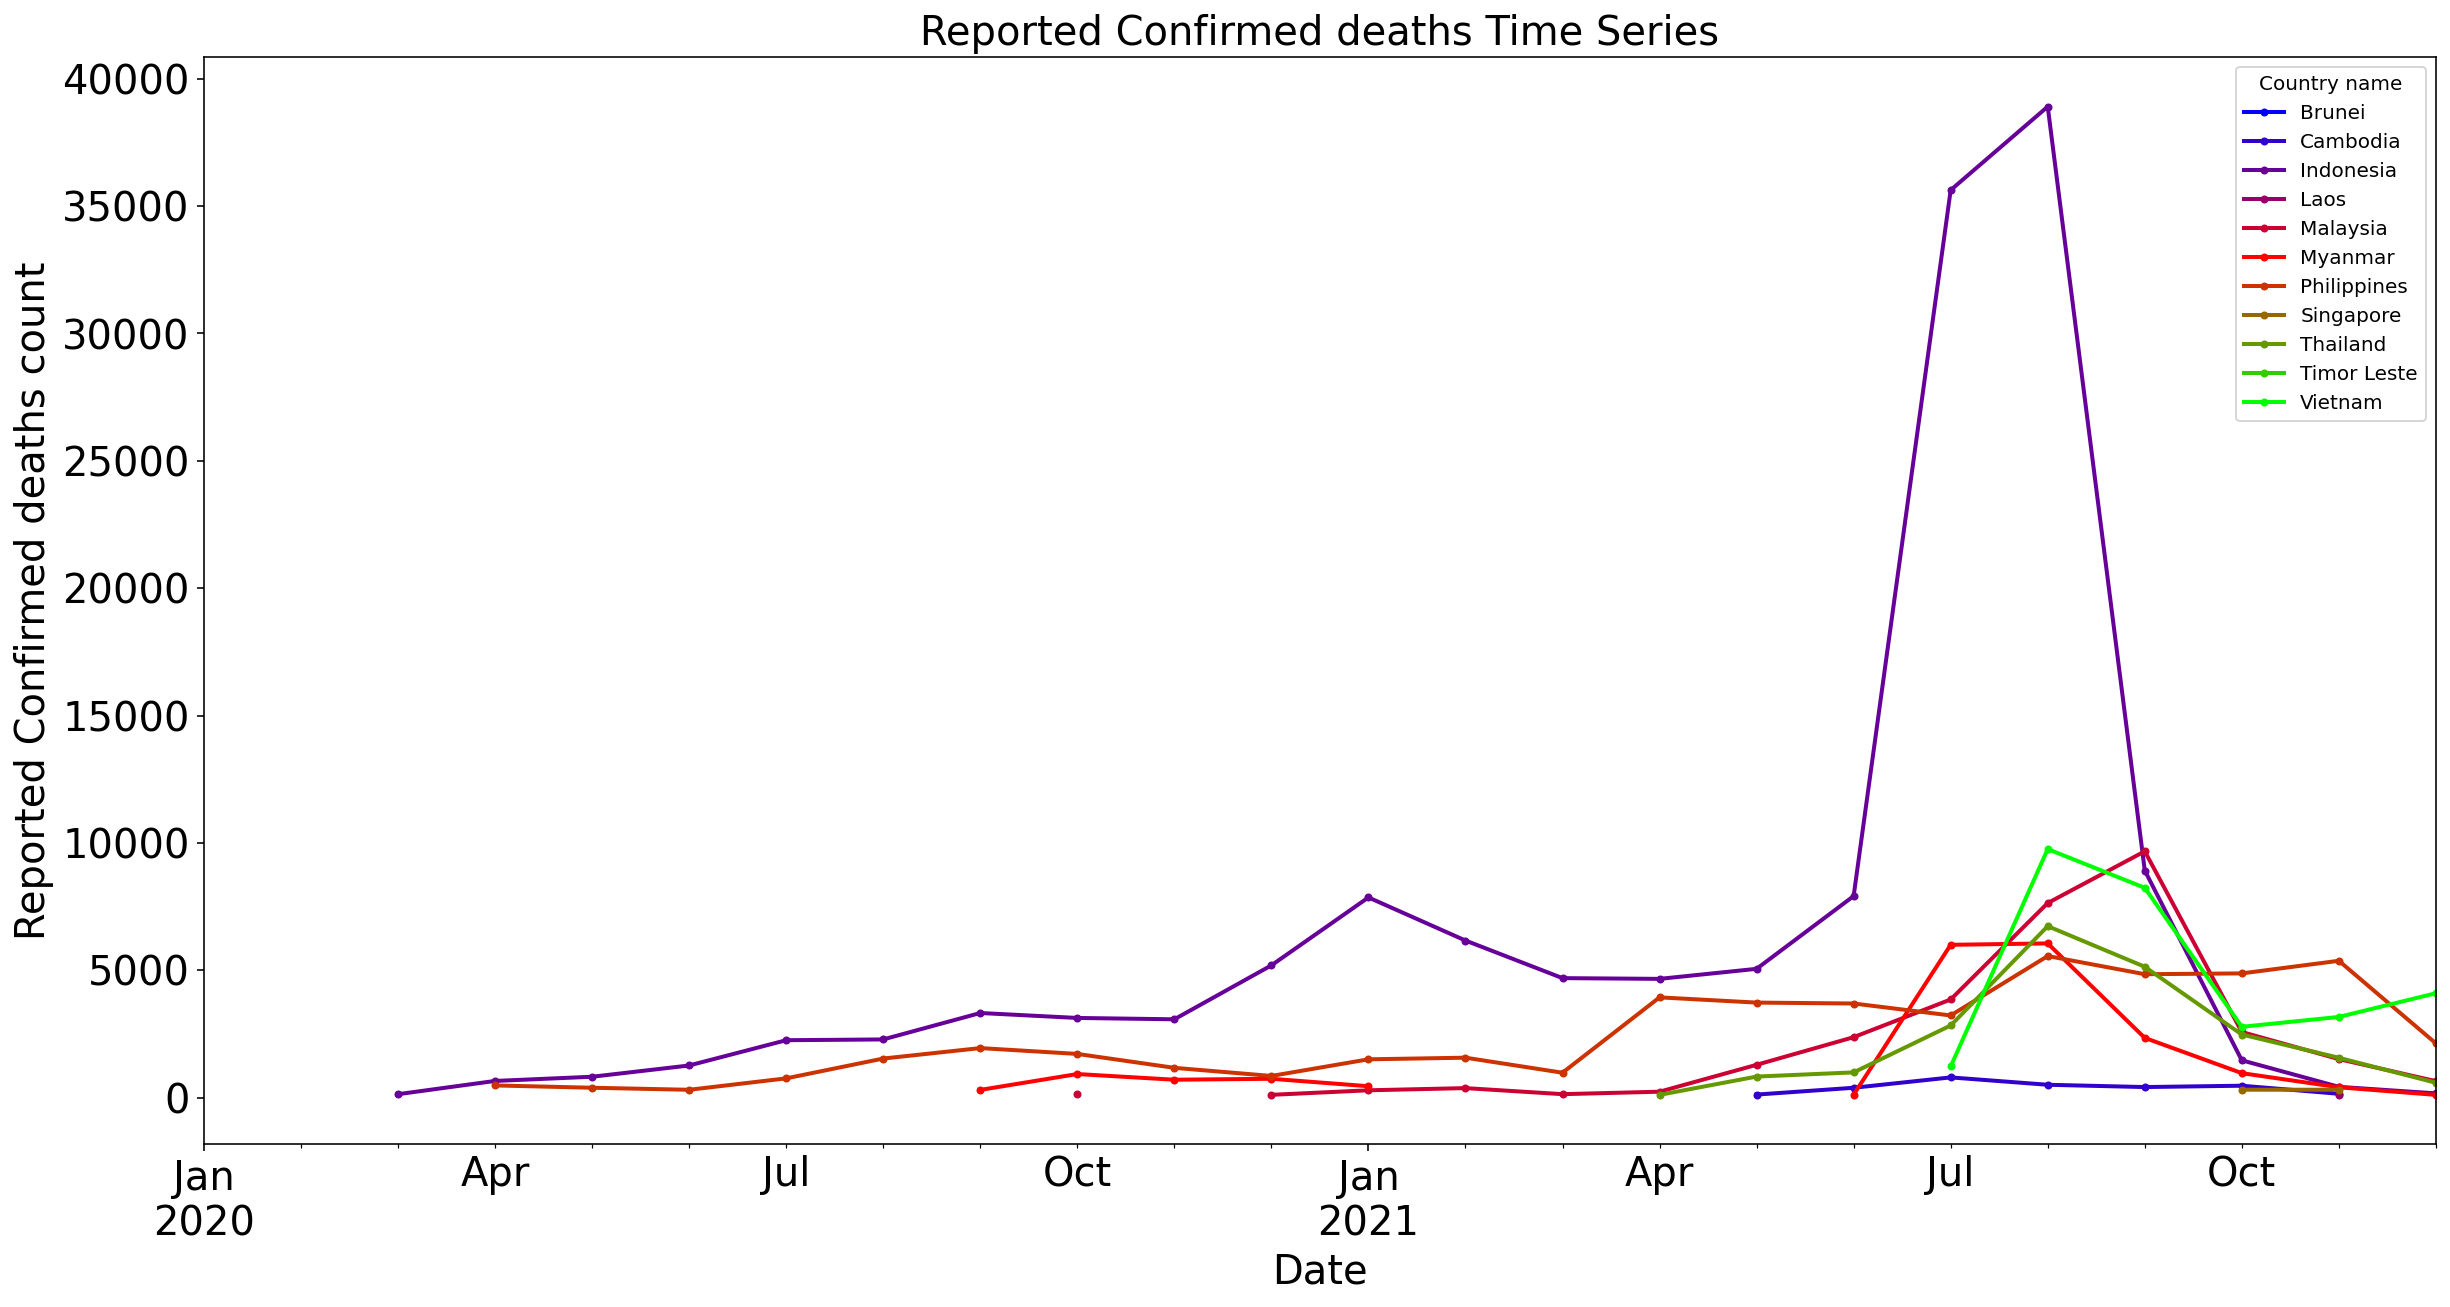

In [248]:
# Plot time series of several countries of interest
df_deaths.plot(figsize=(20,10), linewidth=2, marker='.', colormap='brg', fontsize=20)
plt.xlabel('Date', fontsize=20);
plt.ylabel('Reported Confirmed deaths count', fontsize=20);
plt.title('Reported Confirmed deaths Time Series', fontsize=20);

## Number of new cases vs number of new vaccineinations

In [249]:
df_vn = covid_19[covid_19['Country name']=='Vietnam']

In [250]:
df_vn['Date'] = pd.to_datetime(df_vn['Date'], format='%Y-%m-%d')
df_vn.set_index('Date', inplace=True, drop = False)
df_vn = df_vn.resample('MS').agg({'New cases':'sum','New deaths':'sum', 'New vaccineinations':'sum', 'Stringency index':'mean'})
df_vn

/var/folders/bn/rrr4fsw14591zqtjsxz419z40000gn/T/ipykernel_10272/1779601259.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,New cases,New deaths,New vaccineinations,Stringency index
Date,,,,
2020-01-01,2.0,0.0,0.0,9.570000
2020-02-01,14.0,0.0,0.0,40.866897
2020-03-01,196.0,0.0,0.0,53.492903
2020-04-01,58.0,0.0,0.0,88.814000
2020-05-01,58.0,0.0,0.0,71.473548
2020-06-01,27.0,0.0,0.0,63.331000
2020-07-01,203.0,3.0,0.0,58.725161
2020-08-01,486.0,31.0,0.0,77.775161
2020-09-01,50.0,1.0,0.0,75.754333


In [251]:
df_vn['Date'] = df_vn.index
df_vn

,New cases,New deaths,New vaccineinations,Stringency index,Date
Date,,,,,
2020-01-01,2.0,0.0,0.0,9.570000,2020-01-01
2020-02-01,14.0,0.0,0.0,40.866897,2020-02-01
2020-03-01,196.0,0.0,0.0,53.492903,2020-03-01
2020-04-01,58.0,0.0,0.0,88.814000,2020-04-01
2020-05-01,58.0,0.0,0.0,71.473548,2020-05-01
2020-06-01,27.0,0.0,0.0,63.331000,2020-06-01
2020-07-01,203.0,3.0,0.0,58.725161,2020-07-01
2020-08-01,486.0,31.0,0.0,77.775161,2020-08-01
2020-09-01,50.0,1.0,0.0,75.754333,2020-09-01


In [252]:
df_vn.reset_index(drop=True, inplace=True)
df_vn

,New cases,New deaths,New vaccineinations,Stringency index,Date
0,2.0,0.0,0.0,9.570000,2020-01-01
1,14.0,0.0,0.0,40.866897,2020-02-01
2,196.0,0.0,0.0,53.492903,2020-03-01
3,58.0,0.0,0.0,88.814000,2020-04-01
4,58.0,0.0,0.0,71.473548,2020-05-01
5,27.0,0.0,0.0,63.331000,2020-06-01
6,203.0,3.0,0.0,58.725161,2020-07-01
7,486.0,31.0,0.0,77.775161,2020-08-01
8,50.0,1.0,0.0,75.754333,2020-09-01
9,86.0,0.0,0.0,58.330000,2020-10-01


In [253]:
df_vn['Date']=df_vn['Date'].apply(lambda x: str(x.year) + '-' + str(x.month))
df_vn

,New cases,New deaths,New vaccineinations,Stringency index,Date
0,2.0,0.0,0.0,9.570000,2020-1
1,14.0,0.0,0.0,40.866897,2020-2
2,196.0,0.0,0.0,53.492903,2020-3
3,58.0,0.0,0.0,88.814000,2020-4
4,58.0,0.0,0.0,71.473548,2020-5
5,27.0,0.0,0.0,63.331000,2020-6
6,203.0,3.0,0.0,58.725161,2020-7
7,486.0,31.0,0.0,77.775161,2020-8
8,50.0,1.0,0.0,75.754333,2020-9
9,86.0,0.0,0.0,58.330000,2020-10


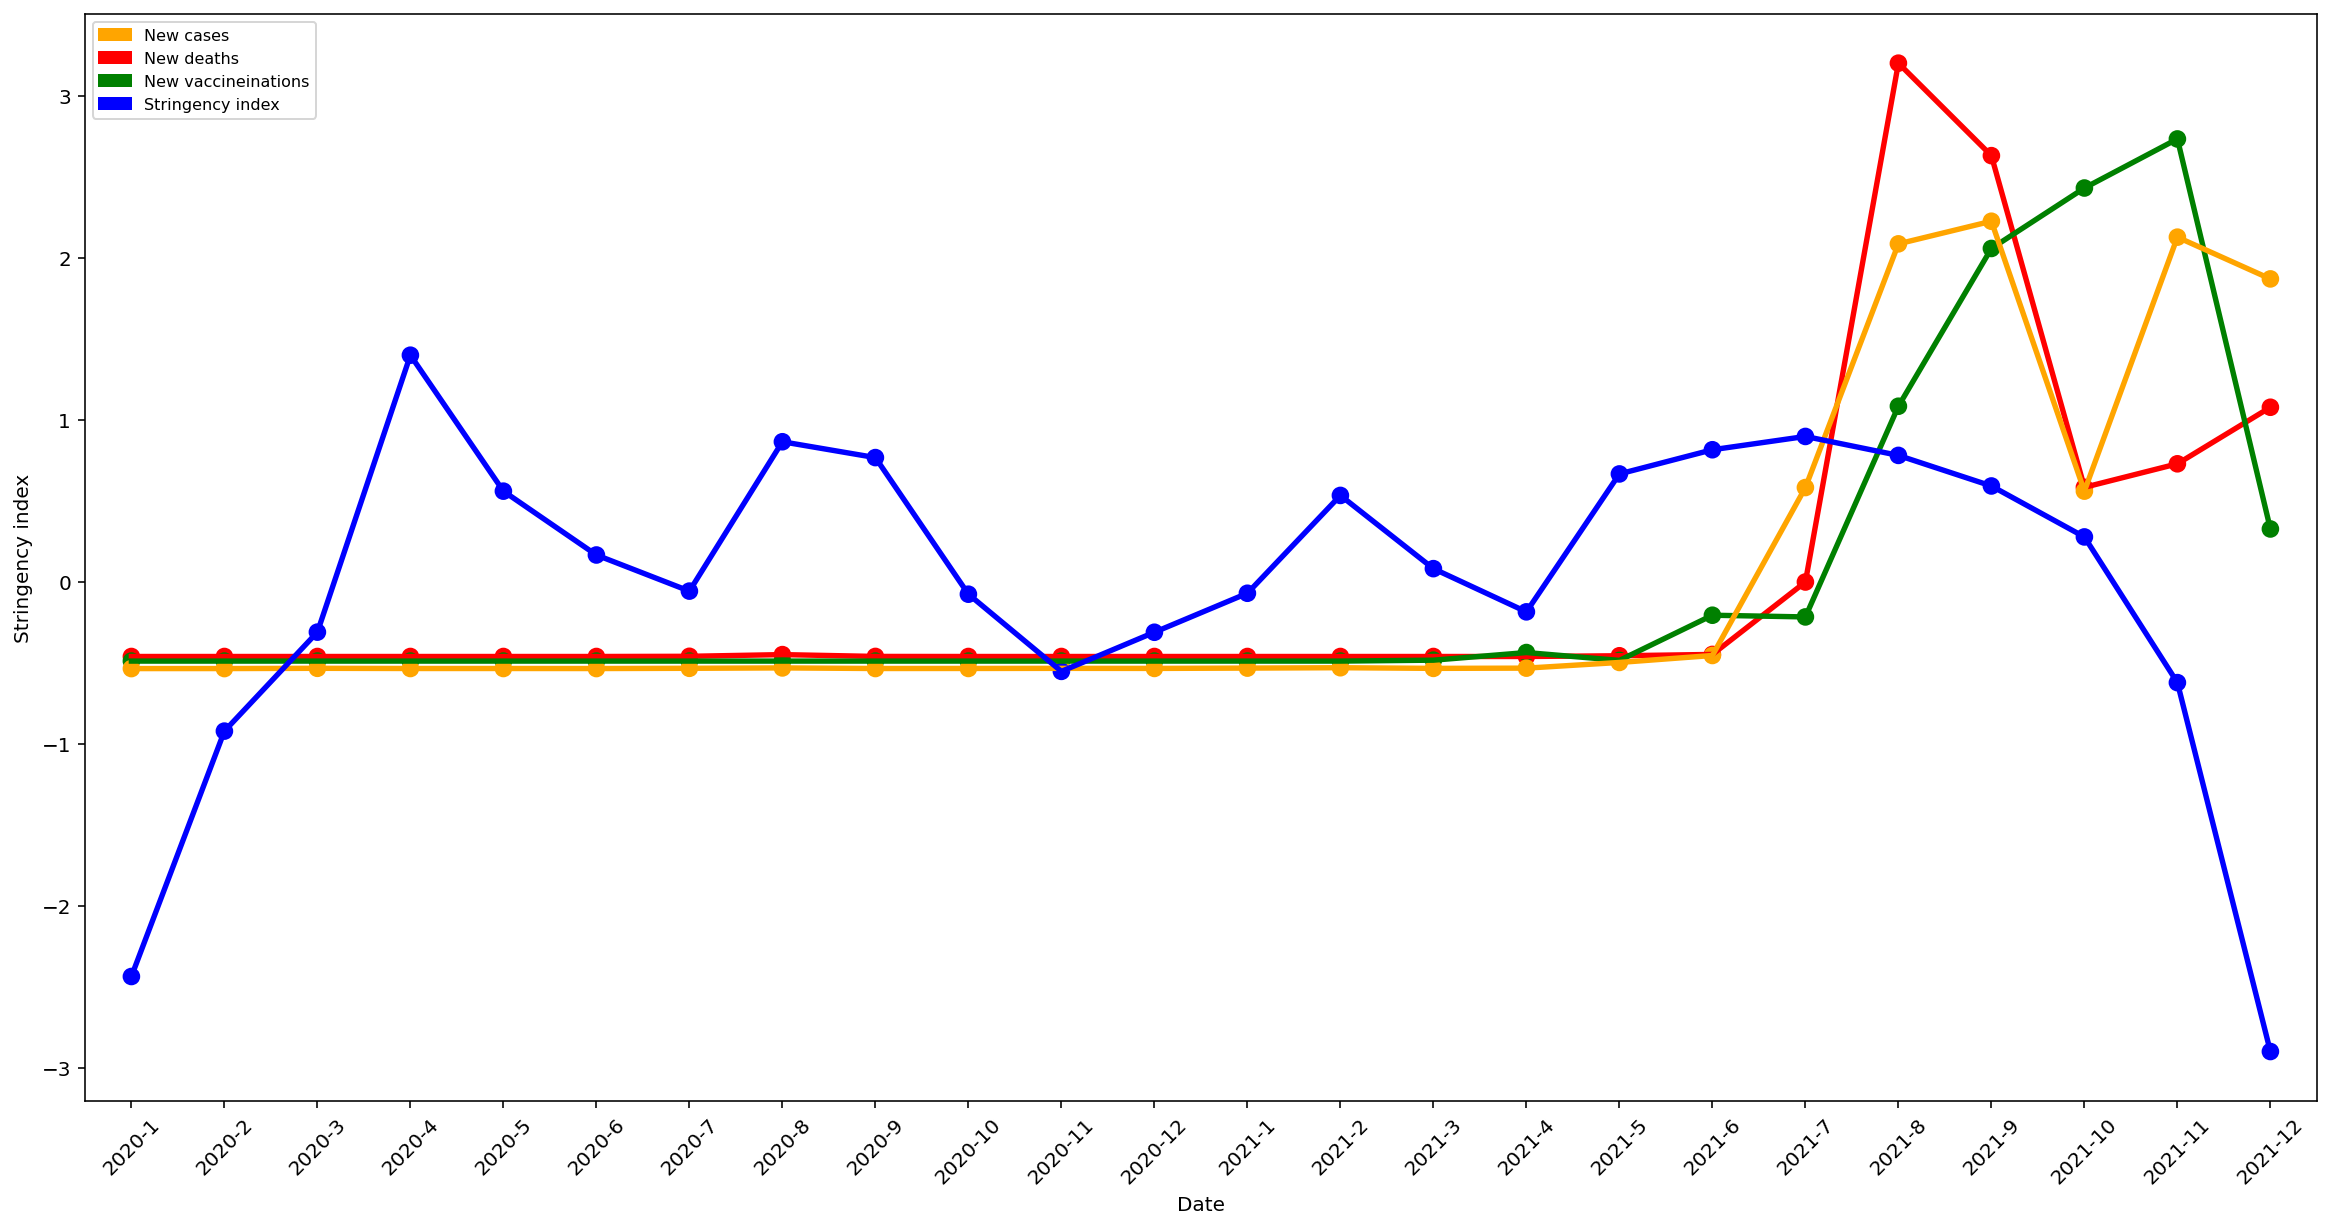

In [278]:
normalised_df = pd.DataFrame()
normalised_df['New cases'] = df_vn['New cases']
normalised_df['New deaths'] = df_vn['New deaths']
normalised_df['New vaccineinations'] = df_vn['New vaccineinations']
normalised_df['Stringency index'] = df_vn['Stringency index']

normalised_df = (normalised_df - normalised_df.mean()) / normalised_df.std()
normalised_df['Date'] = df_vn['Date']


plt.figure(figsize=(20, 10))
ax = sns.pointplot(x = normalised_df['Date'], y = normalised_df['New deaths'], color = 'red', label='People')
ax = sns.pointplot(x = normalised_df['Date'], y = normalised_df['New vaccineinations'], color = 'green', label='People')
ax = sns.pointplot(x = normalised_df['Date'], y = normalised_df['New cases'], color = 'orange', label='Month')
ax = sns.pointplot(x = normalised_df['Date'], y = normalised_df['Stringency index'], color = 'blue', label='People')



orange_patch = mpatches.Patch(color='orange', label='New cases')
red_patch = mpatches.Patch(color='red', label='New deaths')
green_patch = mpatches.Patch(color='green', label='New vaccineinations')
blue_patch = mpatches.Patch(color='blue', label='Stringency index')


plt.legend(handles=[orange_patch, red_patch, green_patch, blue_patch], loc='upper left', fontsize = 8)

plt.xticks(rotation=45);

## Number of new cases vs Stringency index

In [255]:
df_vn_1 = df_vn[df_vn.index < 16]
df_vn_1

,New cases,New deaths,New vaccineinations,Stringency index,Date
0,2.0,0.0,0.0,9.570000,2020-1
1,14.0,0.0,0.0,40.866897,2020-2
2,196.0,0.0,0.0,53.492903,2020-3
3,58.0,0.0,0.0,88.814000,2020-4
4,58.0,0.0,0.0,71.473548,2020-5
5,27.0,0.0,0.0,63.331000,2020-6
6,203.0,3.0,0.0,58.725161,2020-7
7,486.0,31.0,0.0,77.775161,2020-8
8,50.0,1.0,0.0,75.754333,2020-9
9,86.0,0.0,0.0,58.330000,2020-10


In [256]:
df_vn_2 = df_vn[df_vn.index >= 16]
df_vn_2

,New cases,New deaths,New vaccineinations,Stringency index,Date
16,4504.0,12.0,37208.0,73.669677,2021-5
17,9620.0,34.0,2520356.0,76.755000,2021-6
18,133008.0,1225.0,2426886.0,78.451935,2021-7
19,312036.0,9758.0,14006515.0,76.034516,2021-8
20,328659.0,8237.0,22677776.0,72.134000,2021-9
21,130367.0,2782.0,25999970.0,65.634839,2021-10
22,316960.0,3169.0,28697044.0,47.052667,2021-11
23,286286.0,4099.0,7260966.0,0.000000,2021-12


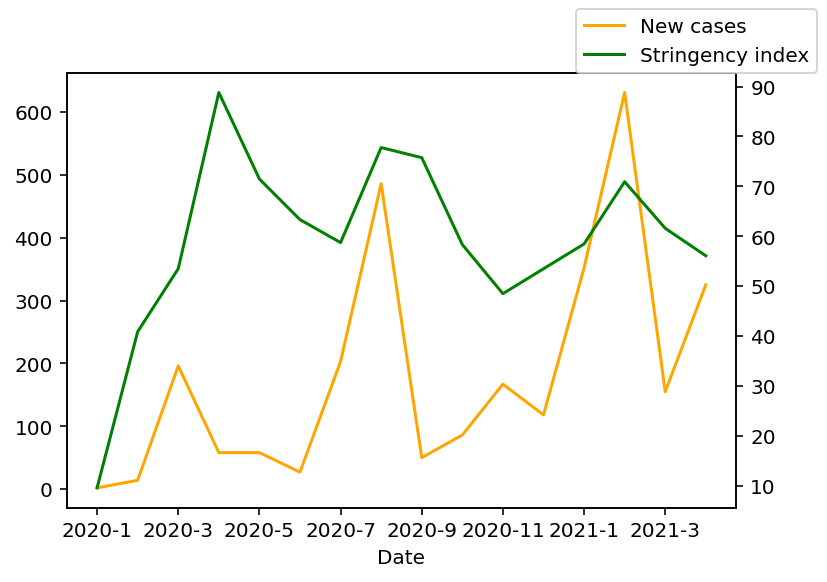

In [257]:
ax = df_vn_1.plot(x="Date", y="New cases", legend=False, color='orange')
ax2 = ax.twinx()
df_vn_1.plot(x="Date", y="Stringency index", ax=ax2, legend=False, color="g")
ax.figure.legend()
plt.show()

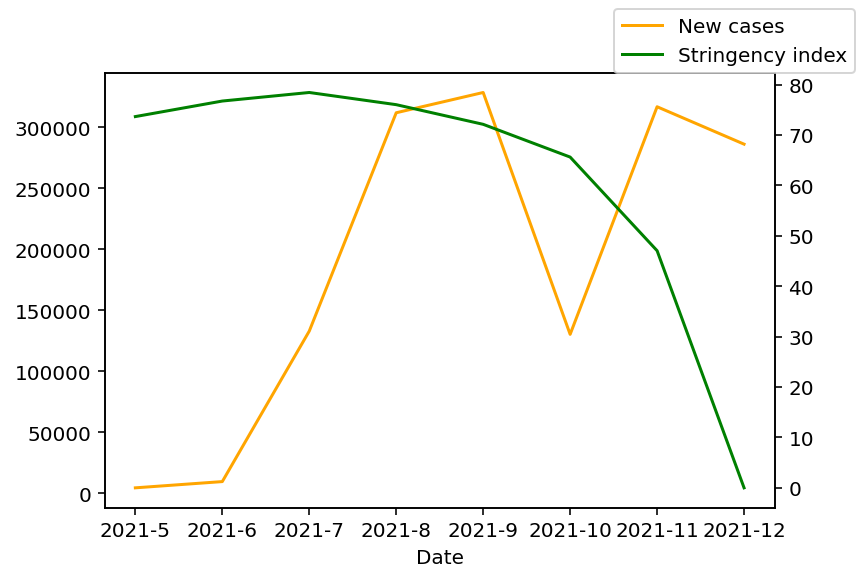

In [258]:
ax = df_vn_2.plot(x="Date", y="New cases", legend=False, color='orange')
ax2 = ax.twinx()
df_vn_2.plot(x="Date", y="Stringency index", ax=ax2, legend=False, color="g")
ax.figure.legend()
plt.show()

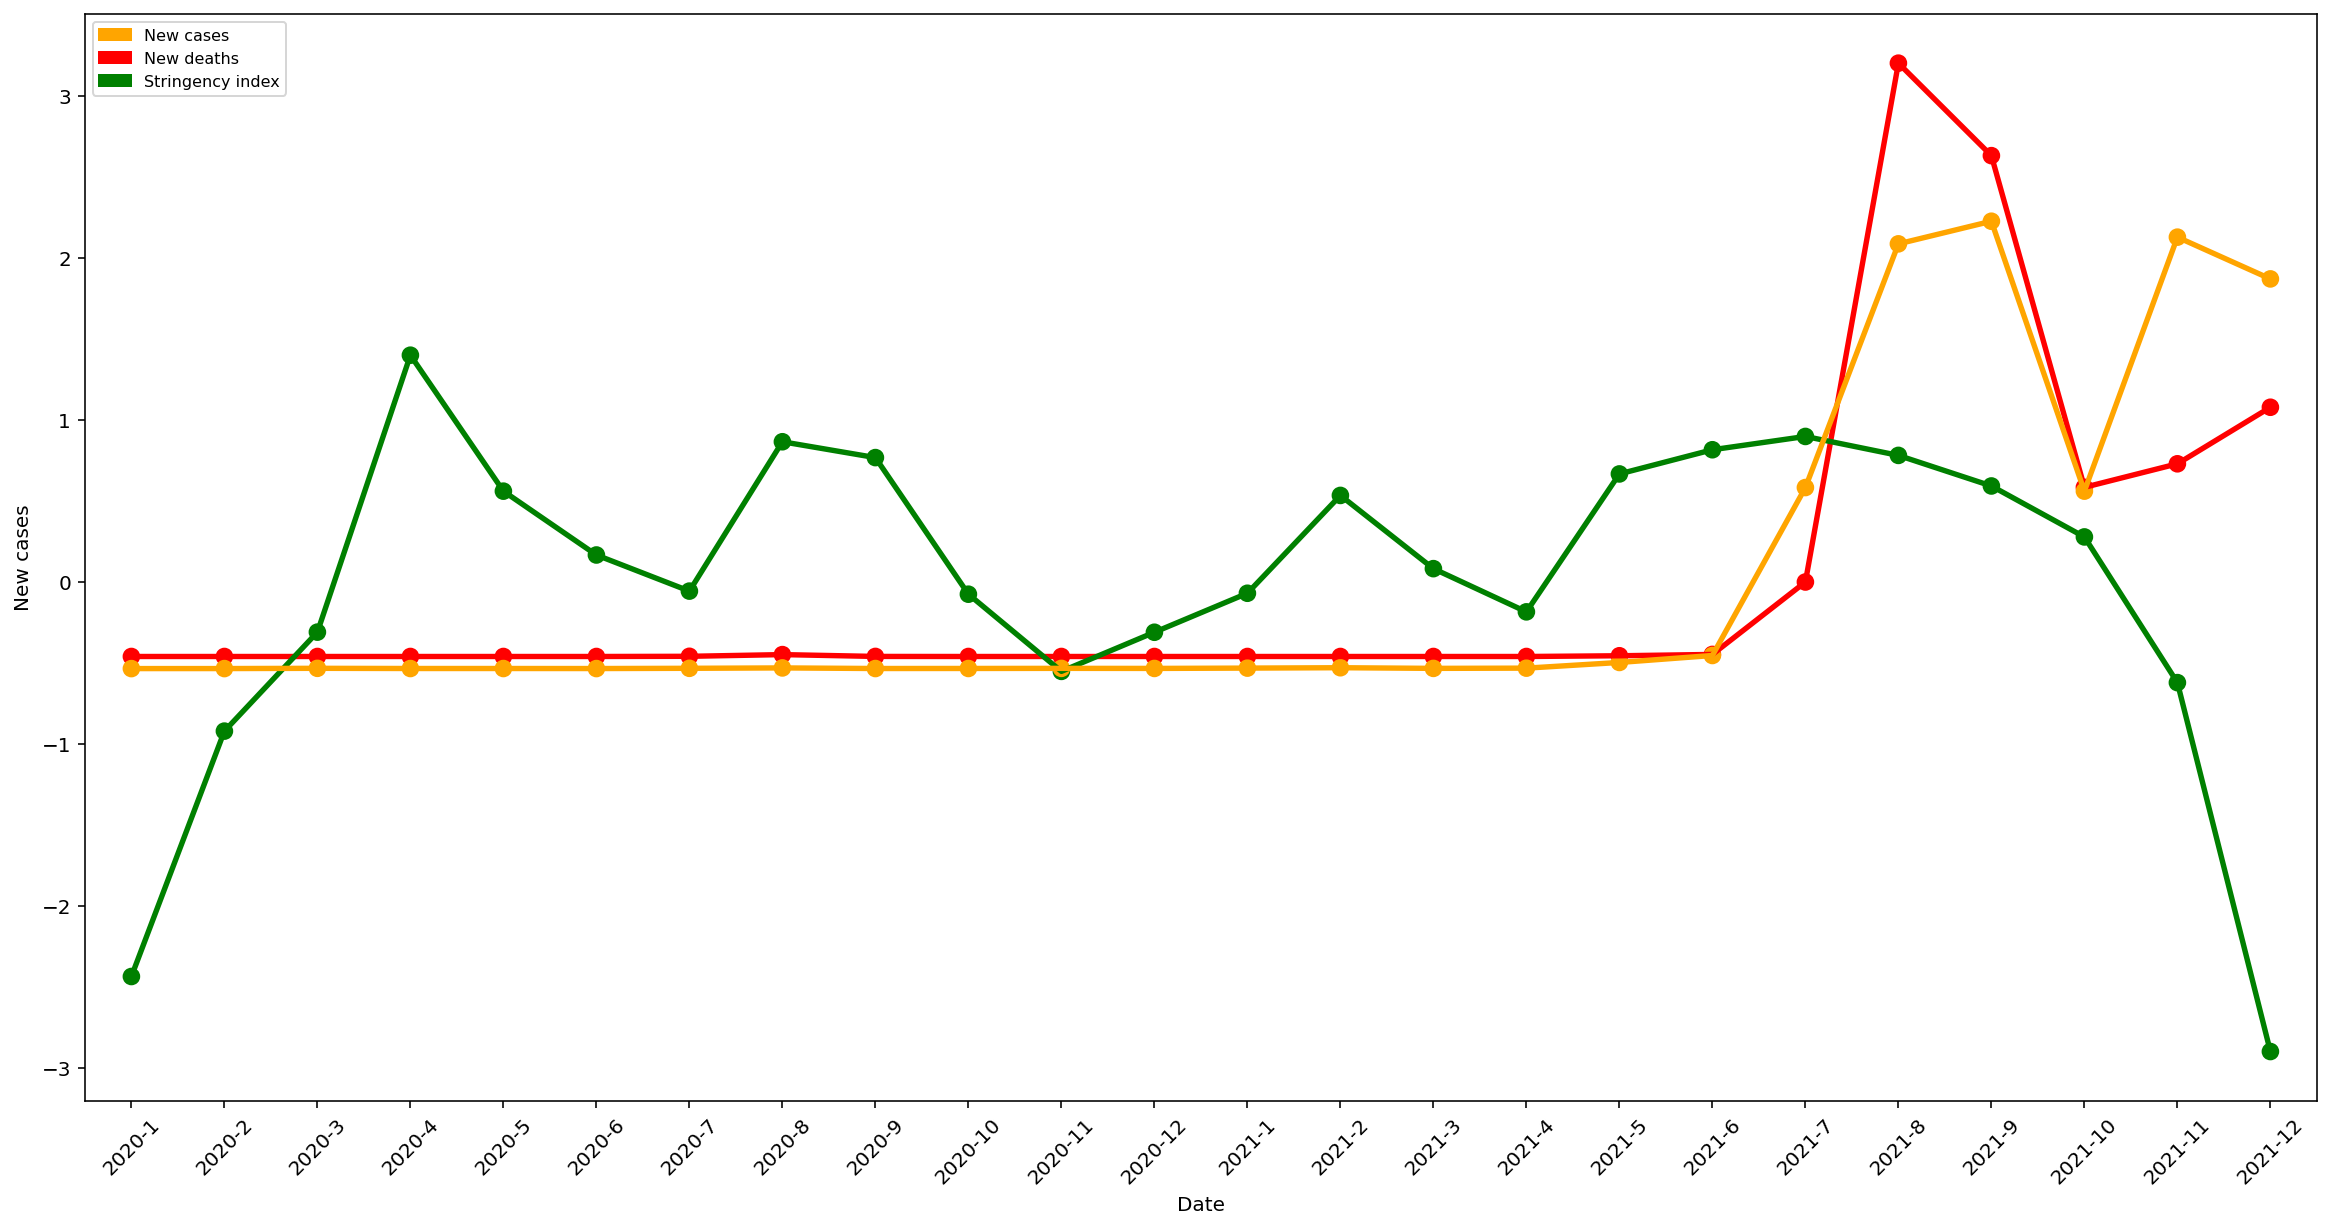

In [259]:
normalised_df = pd.DataFrame()
normalised_df['New cases'] = df_vn['New cases']
normalised_df['New deaths'] = df_vn['New deaths']
normalised_df['Stringency index'] = df_vn['Stringency index']

normalised_df = (normalised_df - normalised_df.mean()) / normalised_df.std()
normalised_df['Date'] = df_vn['Date']


plt.figure(figsize=(20, 10))
ax = sns.pointplot(x = normalised_df['Date'], y = normalised_df['New deaths'], color = 'red', label='People')
ax = sns.pointplot(x = normalised_df['Date'], y = normalised_df['Stringency index'], color = 'green', label='People')
ax = sns.pointplot(x = normalised_df['Date'], y = normalised_df['New cases'], color = 'orange', label='Month')


orange_patch = mpatches.Patch(color='orange', label='New cases')
red_patch = mpatches.Patch(color='red', label='New deaths')
green_patch = mpatches.Patch(color='green', label='Stringency index')
plt.legend(handles=[orange_patch, red_patch, green_patch], loc='upper left', fontsize = 8)

plt.xticks(rotation=45);

In [260]:
column_sum = ['Total cases', 'Total deaths', 'Population', 'Area','GDP']
column_mean = ['Median age', 'Average rainfall', 'Average temperature']
sea_data = {}
for column in df.columns:
    if column in column_sum:
        sea_data[column] = df[column].sum()
    if column in column_mean:
        sea_data[column] = df[column].mean()
sea_data

{'Total cases': 14583665.0,
 'Total deaths': 299966.0,
 'Population': 668619840,
 'Area': 4537819,
 'GDP': 2767878591257.0,
 'Median age': 28.236363636363635,
 'Average rainfall': 2174.181818181818,
 'Average temperature': 24.45909090909091}

In [261]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 0 to 10
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country name         11 non-null     object 
 1   Total cases          11 non-null     float64
 2   Total deaths         11 non-null     float64
 3   Population           11 non-null     int64  
 4   Area                 11 non-null     int64  
 5   GDP                  11 non-null     float64
 6   Median age           11 non-null     float64
 7   Average rainfall     11 non-null     int64  
 8   Average temperature  11 non-null     float64
dtypes: float64(5), int64(3), object(1)
memory usage: 880.0+ bytes


In [262]:
df.loc['11'] = sea_data
df.at['11', 'Country name'] = 'Southeast Asia'
df

,Country name,Total cases,Total deaths,Population,Area,GDP,Median age,Average rainfall,Average temperature
0,Brunei,15386.0,98.0,437479,5765,1.212809e+10,30.200000,2722.000000,26.850000
1,Cambodia,120410.0,3003.0,16718965,181035,2.215821e+10,25.300000,1904.000000,26.800000
2,Indonesia,4260380.0,143998.0,273523615,1904569,1.015421e+12,30.200000,2702.000000,25.850000
3,Laos,97505.0,268.0,7275560,236800,1.685309e+10,23.000000,1834.000000,22.800000
4,Malaysia,2715847.0,31073.0,32365999,330803,3.147103e+11,28.500000,2875.000000,25.400000
5,Myanmar,528101.0,19213.0,54409800,676578,6.706875e+10,28.200000,2091.000000,13.050000
6,Philippines,2837555.0,50675.0,109581078,342353,3.135952e+11,23.500000,2348.000000,25.850000
7,Singapore,275655.0,810.0,5850342,710,3.239072e+11,34.600000,2497.000000,26.450000
8,Thailand,2188625.0,21355.0,69799978,513120,4.553027e+11,37.700000,1622.000000,26.300000
9,Timor Leste,19833.0,122.0,1318445,14874,2.954621e+09,18.900000,1500.000000,25.250000


<AxesSubplot:>

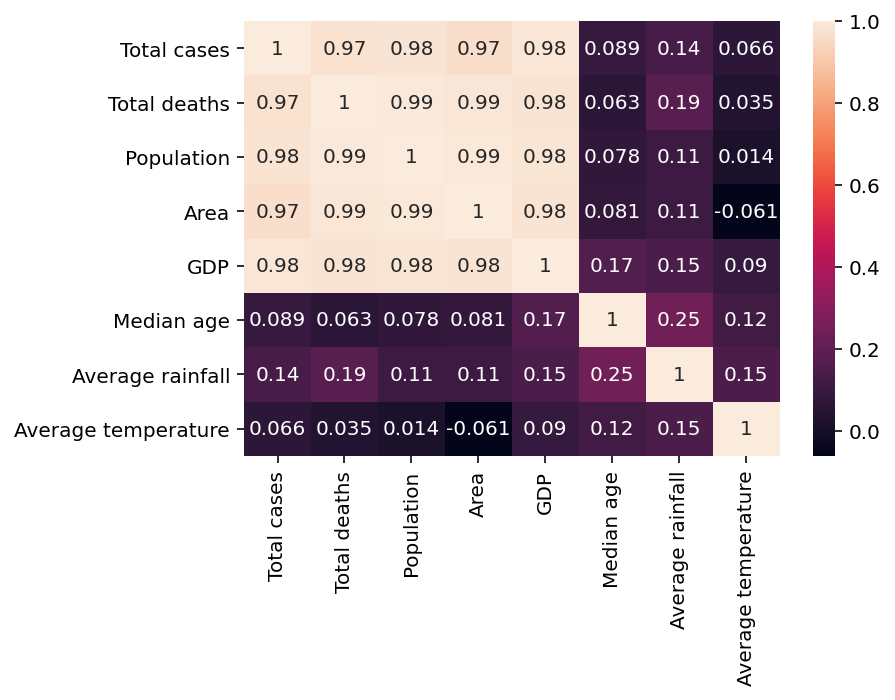

In [263]:
corelation = df.corr(method='pearson')
sns.heatmap(corelation, xticklabels=corelation.columns, yticklabels=corelation.columns, annot=True)

<AxesSubplot:>

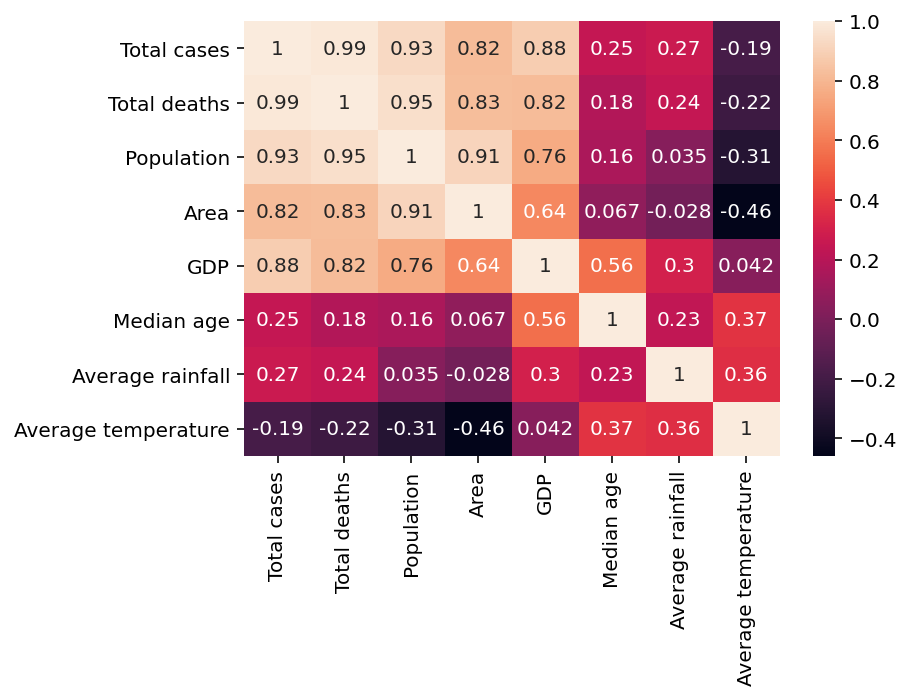

In [264]:
corelation = df.corr(method='spearman')
sns.heatmap(corelation, xticklabels=corelation.columns, yticklabels=corelation.columns, annot=True)

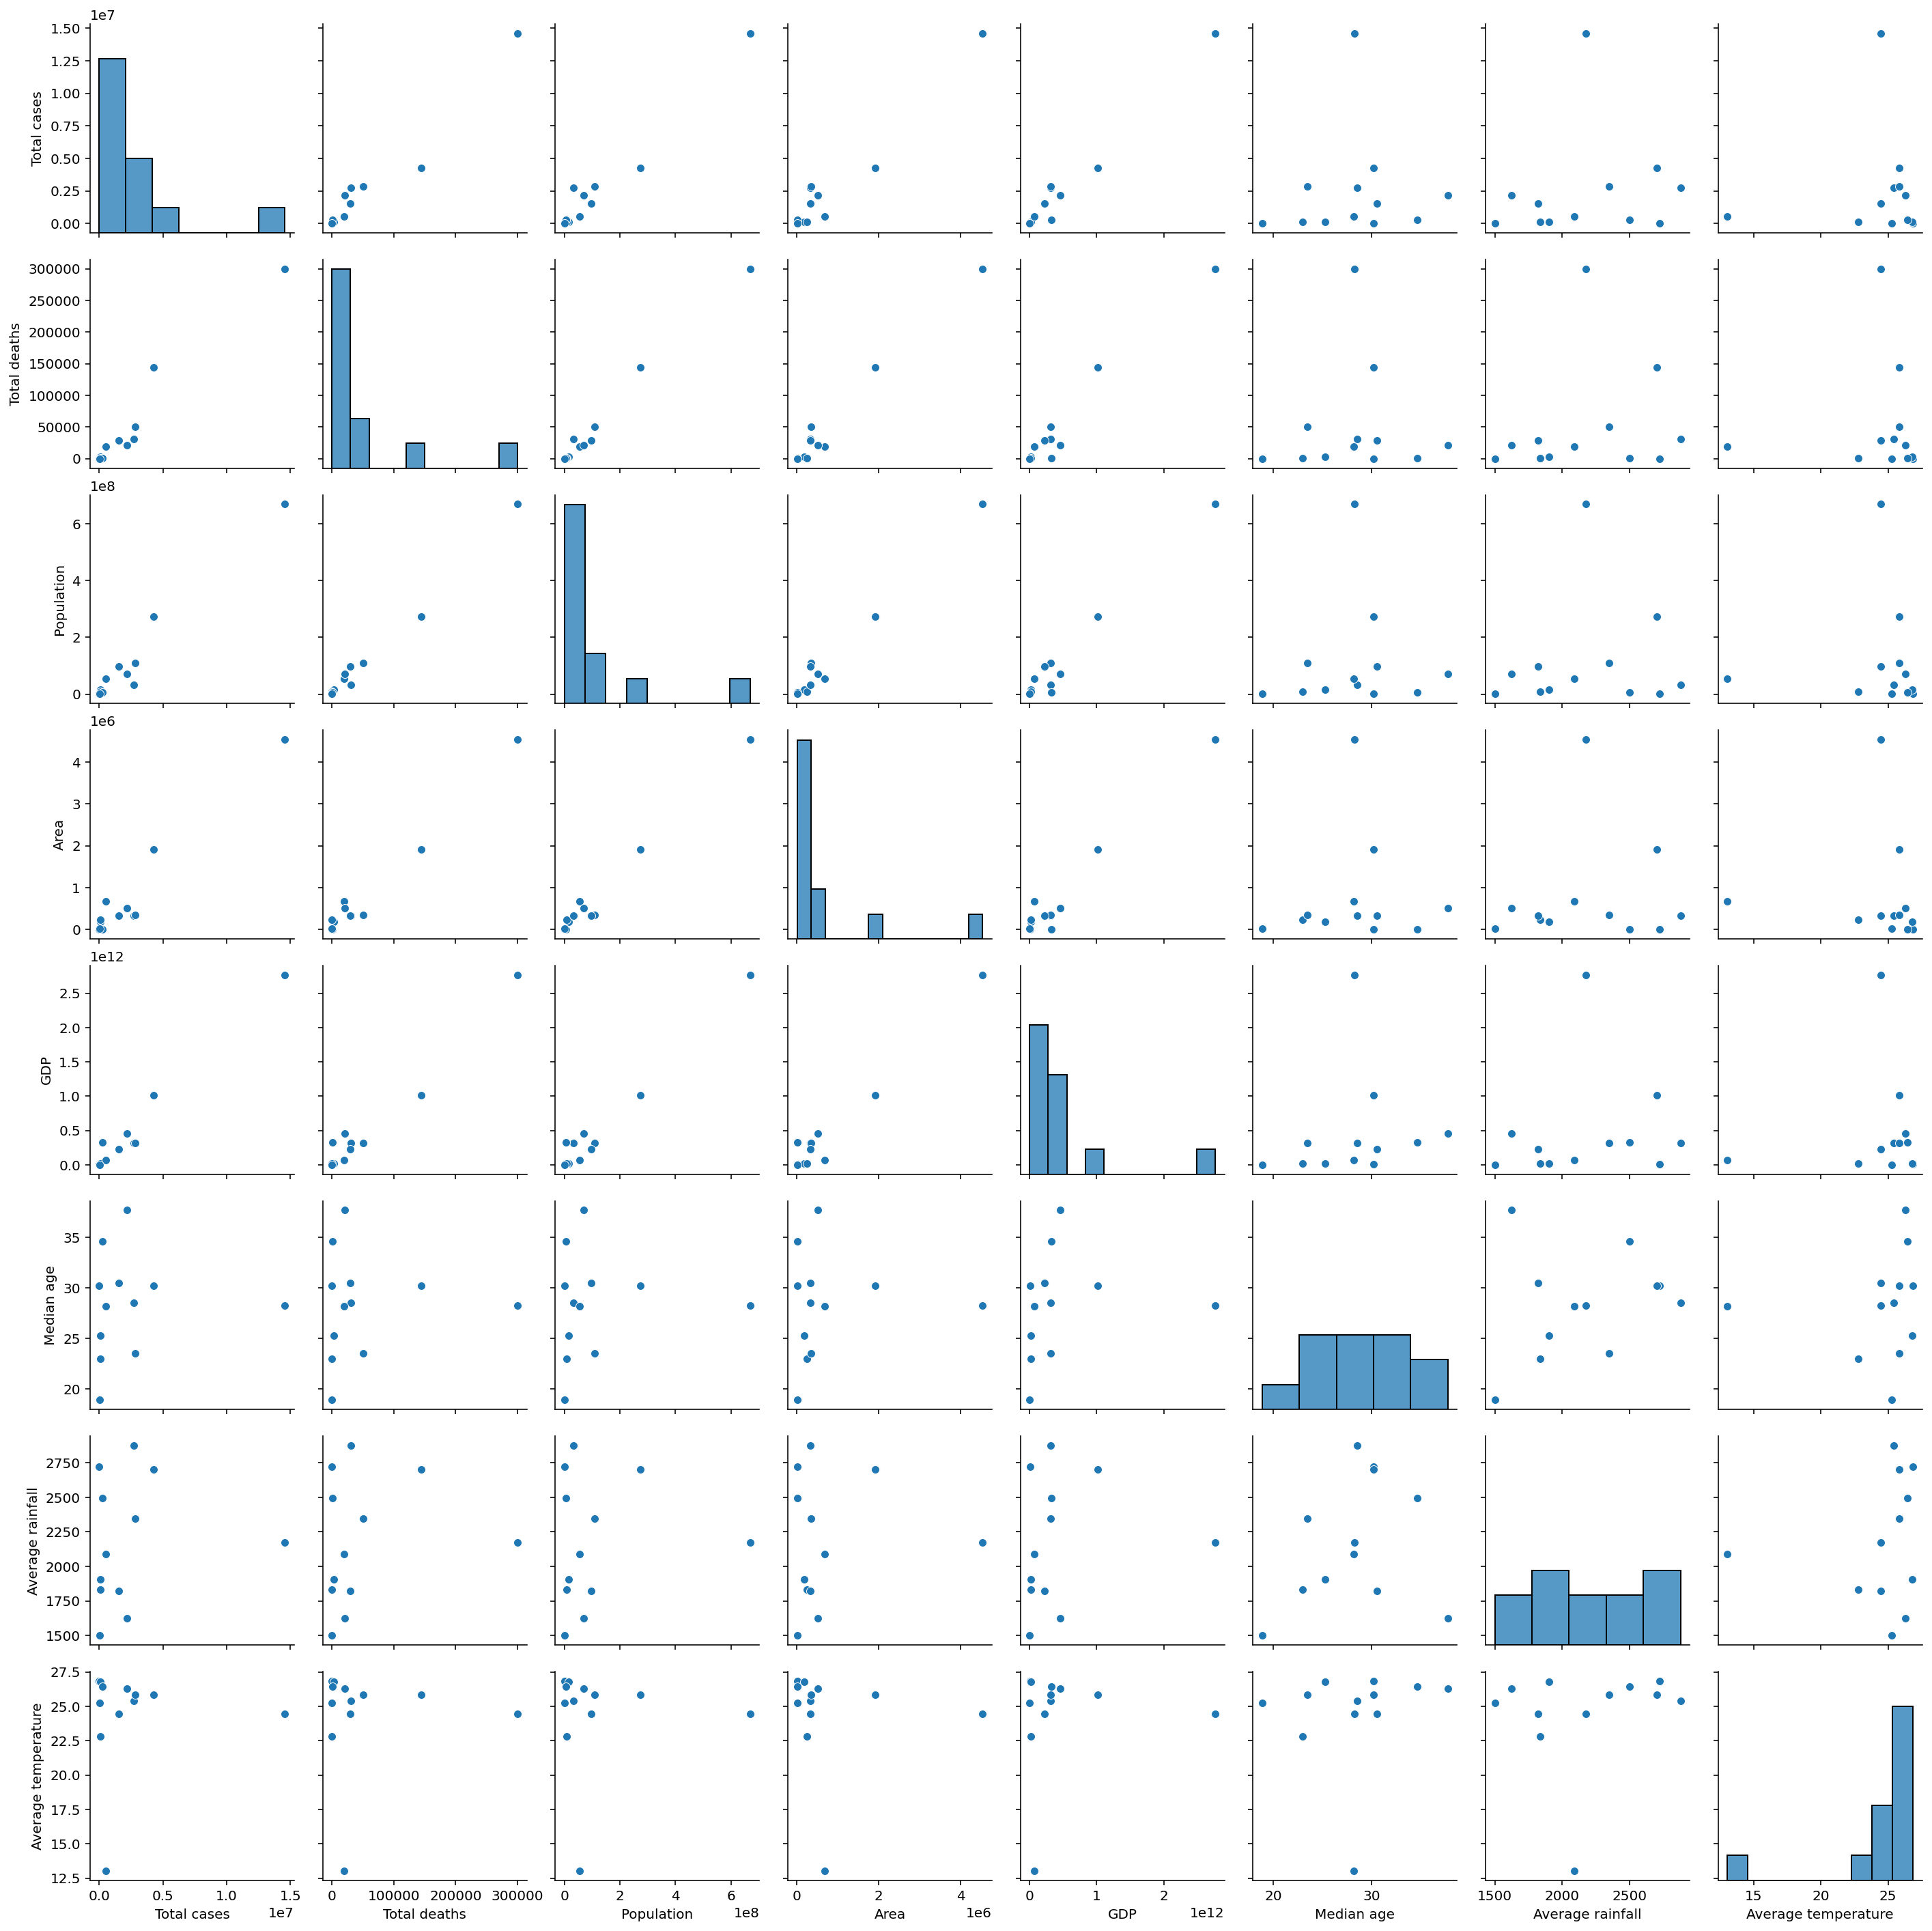

In [265]:
sns.pairplot(df)

In [266]:
df

,Country name,Total cases,Total deaths,Population,Area,GDP,Median age,Average rainfall,Average temperature
0,Brunei,15386.0,98.0,437479,5765,1.212809e+10,30.200000,2722.000000,26.850000
1,Cambodia,120410.0,3003.0,16718965,181035,2.215821e+10,25.300000,1904.000000,26.800000
2,Indonesia,4260380.0,143998.0,273523615,1904569,1.015421e+12,30.200000,2702.000000,25.850000
3,Laos,97505.0,268.0,7275560,236800,1.685309e+10,23.000000,1834.000000,22.800000
4,Malaysia,2715847.0,31073.0,32365999,330803,3.147103e+11,28.500000,2875.000000,25.400000
5,Myanmar,528101.0,19213.0,54409800,676578,6.706875e+10,28.200000,2091.000000,13.050000
6,Philippines,2837555.0,50675.0,109581078,342353,3.135952e+11,23.500000,2348.000000,25.850000
7,Singapore,275655.0,810.0,5850342,710,3.239072e+11,34.600000,2497.000000,26.450000
8,Thailand,2188625.0,21355.0,69799978,513120,4.553027e+11,37.700000,1622.000000,26.300000
9,Timor Leste,19833.0,122.0,1318445,14874,2.954621e+09,18.900000,1500.000000,25.250000


### Total cases and deaths vs Density

In [267]:
df['Density'] = df['Population']/df['Area']
df

,Country name,Total cases,Total deaths,Population,Area,GDP,Median age,Average rainfall,Average temperature,Density
0,Brunei,15386.0,98.0,437479,5765,1.212809e+10,30.200000,2722.000000,26.850000,75.885343
1,Cambodia,120410.0,3003.0,16718965,181035,2.215821e+10,25.300000,1904.000000,26.800000,92.352114
2,Indonesia,4260380.0,143998.0,273523615,1904569,1.015421e+12,30.200000,2702.000000,25.850000,143.614442
3,Laos,97505.0,268.0,7275560,236800,1.685309e+10,23.000000,1834.000000,22.800000,30.724493
4,Malaysia,2715847.0,31073.0,32365999,330803,3.147103e+11,28.500000,2875.000000,25.400000,97.840706
5,Myanmar,528101.0,19213.0,54409800,676578,6.706875e+10,28.200000,2091.000000,13.050000,80.419109
6,Philippines,2837555.0,50675.0,109581078,342353,3.135952e+11,23.500000,2348.000000,25.850000,320.082132
7,Singapore,275655.0,810.0,5850342,710,3.239072e+11,34.600000,2497.000000,26.450000,8239.918310
8,Thailand,2188625.0,21355.0,69799978,513120,4.553027e+11,37.700000,1622.000000,26.300000,136.030515
9,Timor Leste,19833.0,122.0,1318445,14874,2.954621e+09,18.900000,1500.000000,25.250000,88.640917


<AxesSubplot:xlabel='Density', ylabel='Total cases'>

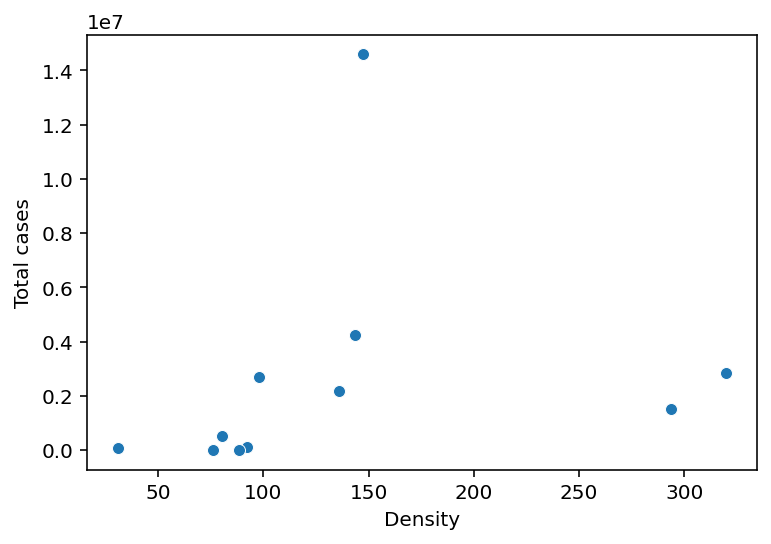

In [268]:
cases_vs_density = df[df['Country name']!='Singapore']
sns.scatterplot(x=cases_vs_density["Density"], y=cases_vs_density["Total cases"])

### Total cases and deaths vs GDP

<AxesSubplot:xlabel='GDP', ylabel='Total cases'>

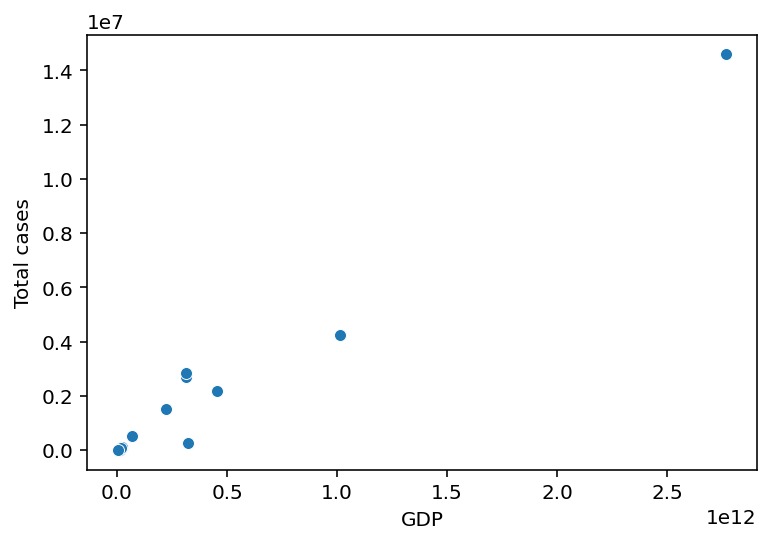

In [269]:
sns.scatterplot(x=df["GDP"], y=df["Total cases"])

<AxesSubplot:xlabel='Average rainfall', ylabel='Total cases'>

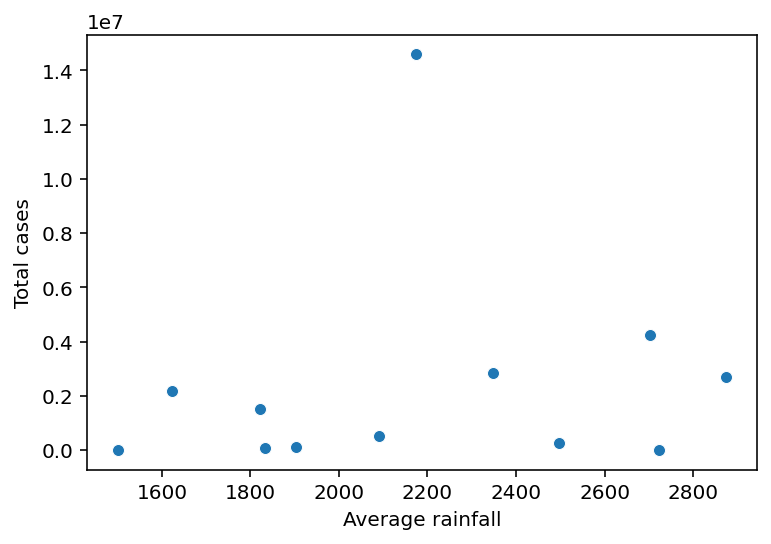

In [270]:
sns.scatterplot(x=df["Average rainfall"], y=df["Total cases"])

In [271]:
df['GDP per capita'] = df['GDP']/df['Population']
df

,Country name,Total cases,Total deaths,Population,Area,GDP,Median age,Average rainfall,Average temperature,Density,GDP per capita
0,Brunei,15386.0,98.0,437479,5765,1.212809e+10,30.200000,2722.000000,26.850000,75.885343,27722.676979
1,Cambodia,120410.0,3003.0,16718965,181035,2.215821e+10,25.300000,1904.000000,26.800000,92.352114,1325.333805
2,Indonesia,4260380.0,143998.0,273523615,1904569,1.015421e+12,30.200000,2702.000000,25.850000,143.614442,3712.368993
3,Laos,97505.0,268.0,7275560,236800,1.685309e+10,23.000000,1834.000000,22.800000,30.724493,2316.397292
4,Malaysia,2715847.0,31073.0,32365999,330803,3.147103e+11,28.500000,2875.000000,25.400000,97.840706,9723.483570
5,Myanmar,528101.0,19213.0,54409800,676578,6.706875e+10,28.200000,2091.000000,13.050000,80.419109,1232.659292
6,Philippines,2837555.0,50675.0,109581078,342353,3.135952e+11,23.500000,2348.000000,25.850000,320.082132,2861.764225
7,Singapore,275655.0,810.0,5850342,710,3.239072e+11,34.600000,2497.000000,26.450000,8239.918310,55365.521266
8,Thailand,2188625.0,21355.0,69799978,513120,4.553027e+11,37.700000,1622.000000,26.300000,136.030515,6522.963130
9,Timor Leste,19833.0,122.0,1318445,14874,2.954621e+09,18.900000,1500.000000,25.250000,88.640917,2240.989196


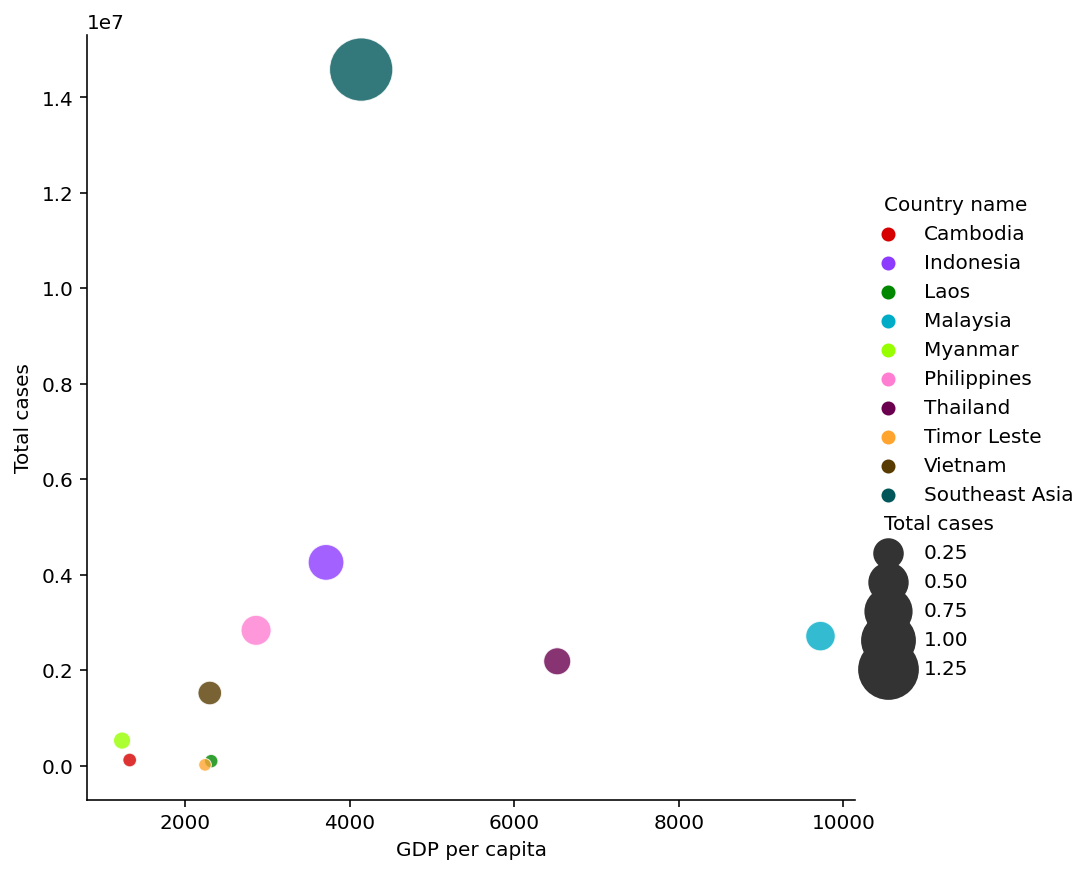

In [272]:
palette = sns.color_palette(cc.glasbey, n_colors=10)

sns.relplot(x="GDP per capita", y="Total cases", hue="Country name", size="Total cases",
            sizes=(40, 1000), alpha=.8, palette=palette,
            height=6, data=df[~df['Country name'].isin(['Singapore', 'Brunei'])])

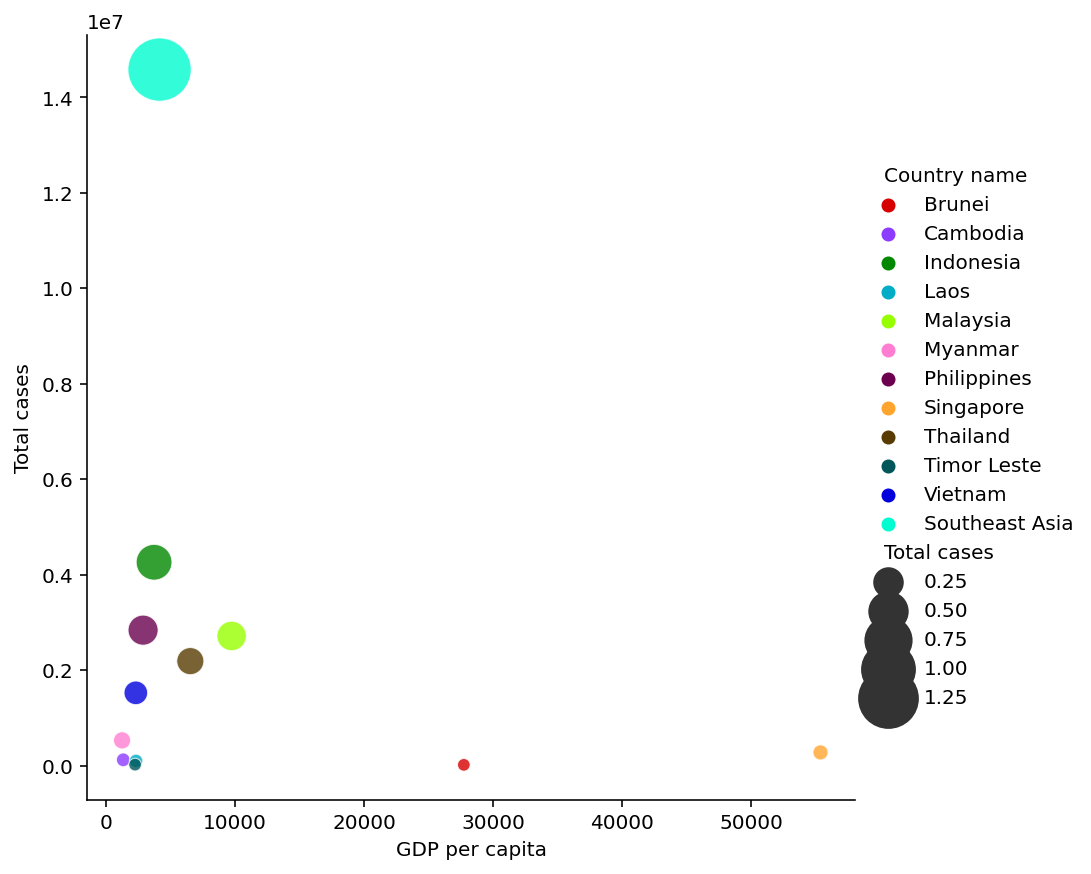

In [273]:
palette = sns.color_palette(cc.glasbey, n_colors=12)

sns.relplot(x="GDP per capita", y="Total cases", hue="Country name", size="Total cases",
            sizes=(40, 1000), alpha=.8, palette=palette,
            height=6, data=df)

In [274]:
plotly.express.pie(df[df['Country name'] != 'Southeast Asia'], values='Total cases', names='Country name',
               title='Total cases', color_discrete_sequence=px.colors.sequential.RdBu)

In [275]:
# fig = plotly.express.bar(covid_19, x="Country name", y="Total cases", color="Country name",
#   animation_frame="Date", animation_group="Country name", range_y=[0, df['Total cases'].max() + 100000])

# fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 20

# fig

In [276]:
exceptions = []

def get_alpha_3_code(cou):
    try:
        if cou=='Laos':
            return 'LAO'
        elif cou =='Timor Leste':
            return 'TLS'
        else:
            return pycountry.countries.search_fuzzy(cou)[0].alpha_3
    except:
        exceptions.append(cou)


df['iso_alpha'] = df['Country name'].apply(lambda x : get_alpha_3_code(x))
df[df['Country name']=='Laos']['iso_alpha'] = 'LAO'
df[df['Country name']=='Timor Leste']['iso_alpha'] = 'TLS'

df

/var/folders/bn/rrr4fsw14591zqtjsxz419z40000gn/T/ipykernel_10272/4159883615.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/bn/rrr4fsw14591zqtjsxz419z40000gn/T/ipykernel_10272/4159883615.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Country name,Total cases,Total deaths,Population,Area,GDP,Median age,Average rainfall,Average temperature,Density,GDP per capita,iso_alpha
0,Brunei,15386.0,98.0,437479,5765,1.212809e+10,30.200000,2722.000000,26.850000,75.885343,27722.676979,BRN
1,Cambodia,120410.0,3003.0,16718965,181035,2.215821e+10,25.300000,1904.000000,26.800000,92.352114,1325.333805,KHM
2,Indonesia,4260380.0,143998.0,273523615,1904569,1.015421e+12,30.200000,2702.000000,25.850000,143.614442,3712.368993,IDN
3,Laos,97505.0,268.0,7275560,236800,1.685309e+10,23.000000,1834.000000,22.800000,30.724493,2316.397292,LAO
4,Malaysia,2715847.0,31073.0,32365999,330803,3.147103e+11,28.500000,2875.000000,25.400000,97.840706,9723.483570,MYS
5,Myanmar,528101.0,19213.0,54409800,676578,6.706875e+10,28.200000,2091.000000,13.050000,80.419109,1232.659292,MMR
6,Philippines,2837555.0,50675.0,109581078,342353,3.135952e+11,23.500000,2348.000000,25.850000,320.082132,2861.764225,PHL
7,Singapore,275655.0,810.0,5850342,710,3.239072e+11,34.600000,2497.000000,26.450000,8239.918310,55365.521266,SGP
8,Thailand,2188625.0,21355.0,69799978,513120,4.553027e+11,37.700000,1622.000000,26.300000,136.030515,6522.963130,THA
9,Timor Leste,19833.0,122.0,1318445,14874,2.954621e+09,18.900000,1500.000000,25.250000,88.640917,2240.989196,TLS


In [277]:
# removeing exceptions
for exc in exceptions:
    df = df[df['Country name']!=exc]
    
    
fig = px.scatter_geo(df, locations="iso_alpha",
                     color="Country name", # which column to use to set the color of markers
                     hover_name="Country name", # column added to hover information
                     size="Total cases", # size of markers
                     projection="orthographic")
fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})
fig